In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf
import warnings
import pickle
import os
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# --- 1. Carga y Exploración de Datos (EDA) ---
print("1. Carga y Exploración de Datos (EDA)")

# Cargar los datos desde los archivos proporcionados
ruta_data_set_train = 'Dataset/train.csv'
ruta_data_set_test = 'Dataset/test.csv'
train_df = pd.read_csv(ruta_data_set_train, delimiter =',')
test_df = pd.read_csv(ruta_data_set_test, delimiter =',')

1. Carga y Exploración de Datos (EDA)


In [4]:
# Convertir 'date' a datetime y establecer como índice
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.set_index('date', inplace=True)

In [5]:
# EDA Básico
print("\nInformación del dataset de entrenamiento:")
train_df.info()
print("\nEstadísticas descriptivas del dataset de entrenamiento:")
print(train_df.describe())
print(f"\nSubestaciones únicas: {train_df['substation'].unique()}")


Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244391 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   substation   244391 non-null  object 
 1   consumption  244391 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.6+ MB

Estadísticas descriptivas del dataset de entrenamiento:
         consumption
count  244391.000000
mean      179.548024
std       156.018729
min      -199.000000
25%         0.181926
50%       172.099977
75%       262.179646
max       752.006309

Subestaciones únicas: ['AJAHUEL' 'BUIN' 'CHENA' 'CNAVIA' 'ELSALTO' 'FLORIDA' 'LOSALME']


In [6]:
# EDA Básico
print("\nInformación del dataset de entrenamiento:")
test_df.info()
print("\nEstadísticas descriptivas del dataset de entrenamiento:")
print(test_df.describe())
print(f"\nSubestaciones únicas: {test_df['substation'].unique()}")


Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61313 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   substation   61313 non-null  object 
 1   consumption  61313 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB

Estadísticas descriptivas del dataset de entrenamiento:
        consumption
count  61313.000000
mean     233.632606
std      233.149765
min      -50.484223
25%       12.803047
50%      192.260054
75%      339.165515
max     1610.284029

Subestaciones únicas: ['AJAHUEL' 'BUIN' 'CHENA' 'CNAVIA' 'ELSALTO' 'FLORIDA' 'LOSALME']


In [7]:
# Visualización del consumo total (agregado diario para claridad)
plt.figure(figsize=(15, 6))
train_df.resample('D')['consumption'].sum().plot(title='Entrenamiento:Consumo Eléctrico Total (Agregado Diario)')
plt.ylabel('Consumo Agregado')
plt.xlabel('Fecha')
plt.grid(True)
plt.savefig('Train_total_consumption_daily.png')
plt.close()

In [8]:
# Visualización del consumo total (agregado diario para claridad)
plt.figure(figsize=(15, 6))
test_df.resample('D')['consumption'].sum().plot(title='Prueba: Consumo Eléctrico Total (Agregado Diario)')
plt.ylabel('Consumo Agregado')
plt.xlabel('Fecha')
plt.grid(True)
plt.savefig('Test_total_consumption_daily.png')
plt.close()

In [9]:
# Visualización para cada subestación en un solo gráfico (agregado diario)
plt.figure(figsize=(4 * len(train_df['substation'].unique()),6))
unique_substations = train_df['substation'].unique()
for substation in unique_substations:
    # Resample to daily and plot
    train_df[train_df['substation'] == substation]['consumption'].resample('D').sum().plot(label=substation)

plt.title('Entrenamiento: Consumo Eléctrico Diario por Subestación')
plt.ylabel('Consumo Diario Agregado')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.savefig('Train_all_substations_daily_consumption.png')
plt.close()

In [10]:
# Visualización para cada subestación en un solo gráfico (agregado diario)
plt.figure(figsize=(4 * len(test_df['substation'].unique()),6))
unique_substations = test_df['substation'].unique()
for substation in unique_substations:
    # Resample to daily and plot
    test_df[test_df['substation'] == substation]['consumption'].resample('D').sum().plot(label=substation)

plt.title('Prueba: Consumo Eléctrico Diario por Subestación')
plt.ylabel('Consumo Diario Agregado')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.savefig('Test_all_substations_daily_consumption.png')
plt.close()

In [20]:
print("\nEjecutar el Test de Dickey-Fuller Aumentado para cada subestación...")
unique_substations = train_df['substation'].unique()

all_hipotesis = []

for substation in unique_substations:

    # 2. Extraer la serie de tiempo (la columna con los valores numéricos)
    serie_de_tiempo = train_df[train_df['substation'] == substation]['consumption']

    # 3. Ejecutar el Test de Dickey-Fuller Aumentado
    #    La función adfuller() devuelve una tupla con varios resultados.
    print(f"Ejecutando el Test de Dickey-Fuller Aumentado (ADF) subestacion : {substation}...")
    resultado_adf = adfuller(serie_de_tiempo)

    # 4. Extraer los valores principales del resultado y mostrarlos de forma clara
    substation_name = substation
    adf_statistic = resultado_adf[0]
    p_value = resultado_adf[1]
    num_lags_used = resultado_adf[2]
    num_observations = resultado_adf[3]
    critical_values = resultado_adf[4]

    print(f'Estadístico ADF: {adf_statistic:.4f}')
    print(f'p-valor: {p_value:.4f}')
    print(f'Número de lags usados: {num_lags_used}')
    print(f'Número de observaciones usadas: {num_observations}')
    print('Valores Críticos:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f} (El estadístico ADF debe ser menor que este valor para ser significativo)')

    # 5. Interpretar el resultado final basándose en el p-valor
    print("\n--- Conclusión del Test ---")
    if p_value > 0.05:
        print(f"El p-valor ({p_value:.4f}) es mayor que el nivel de significancia de 0.05.")
        print("Resultado: No se puede rechazar la Hipótesis Nula (H0).")
        print("Conclusión: La serie de tiempo es probablemente NO ESTACIONARIA.")
        conclusion = "NO ESTACIONARIA"
    else:
        print(f"El p-valor ({p_value:.4f}) es menor o igual al nivel de significancia de 0.05.")
        print("Resultado: Se rechaza la Hipótesis Nula (H0).")
        print("Conclusión: La serie de tiempo es probablemente ESTACIONARIA.")
        conclusion = "ESTACIONARIA"

    hipotesis = {
        'subestacion': substation_name,
        'adf_statistic': adf_statistic,
        'p_value': p_value,
        'num_lags_used': num_lags_used,
        'num_observations': num_observations,
        'critical_values': critical_values,
        'conclusion' : conclusion
    }
    all_hipotesis.append(hipotesis)


Ejecutar el Test de Dickey-Fuller Aumentado para cada subestación...
Ejecutando el Test de Dickey-Fuller Aumentado (ADF) subestacion : AJAHUEL...
Estadístico ADF: -10.3291
p-valor: 0.0000
Número de lags usados: 51
Número de observaciones usadas: 34861
Valores Críticos:
	1%: -3.4305 (El estadístico ADF debe ser menor que este valor para ser significativo)
	5%: -2.8616 (El estadístico ADF debe ser menor que este valor para ser significativo)
	10%: -2.5668 (El estadístico ADF debe ser menor que este valor para ser significativo)

--- Conclusión del Test ---
El p-valor (0.0000) es menor o igual al nivel de significancia de 0.05.
Resultado: Se rechaza la Hipótesis Nula (H0).
Conclusión: La serie de tiempo es probablemente ESTACIONARIA.
Ejecutando el Test de Dickey-Fuller Aumentado (ADF) subestacion : BUIN...
Estadístico ADF: -25.2573
p-valor: 0.0000
Número de lags usados: 52
Número de observaciones usadas: 34860
Valores Críticos:
	1%: -3.4305 (El estadístico ADF debe ser menor que este val

Gráfico 'adf_results_plot.png' guardado con éxito.


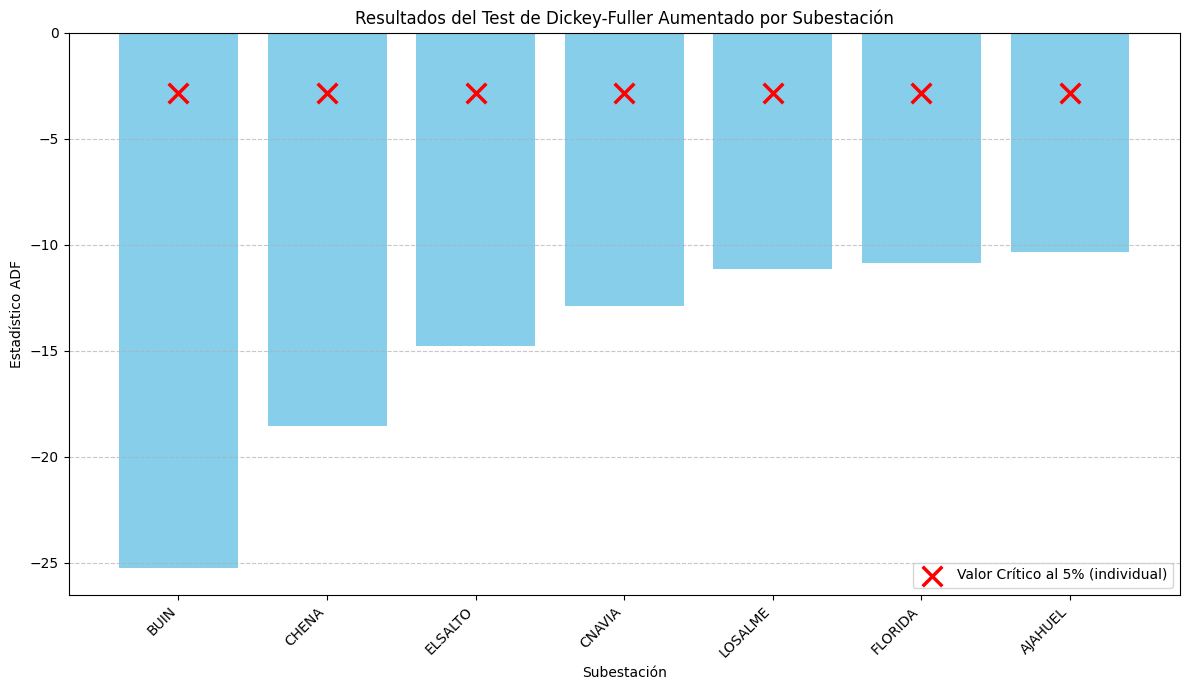

In [28]:
# 2. Convertir la lista de diccionarios a un DataFrame de Pandas
df = pd.DataFrame(all_hipotesis)

# Ordenar el DataFrame por el estadístico ADF para una mejor visualización
df_sorted = df.sort_values('adf_statistic', ascending=True)

# 3. Crear el gráfico de barras
plt.figure(figsize=(12, 7))
bars = plt.bar(df_sorted['subestacion'], df_sorted['adf_statistic'], color='skyblue')

# 4. Añadir una línea para el valor crítico al 5%
# Usamos el valor del primer elemento como referencia, ya que son muy similares
df_sorted['critical_5_percent'] = df_sorted['critical_values'].apply(lambda x: x['5%'])
plt.scatter(x=df_sorted['subestacion'],y=df_sorted['critical_5_percent'],color='red',marker='x',s=200,linewidth=2.5,label='Valor Crítico al 5% (individual)',zorder=5)

# 5. Añadir etiquetas y títulos
plt.ylabel('Estadístico ADF')
plt.xlabel('Subestación')
plt.title('Resultados del Test de Dickey-Fuller Aumentado por Subestación')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X para que no se superpongan
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el diseño para que todo sea visible
plt.tight_layout()

# 6. Guardar el gráfico en un archivo
plt.savefig('Gráfico_de_Autocorrelación/adf_results_plot.png')

print("Gráfico 'adf_results_plot.png' guardado con éxito.")


Graficos de Autocorrelación para cada subestación...
Graficos de Autocorrelación para la subestación: AJAHUEL
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_AJAHUEL.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: BUIN
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_BUIN.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: CHENA
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_CHENA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: CNAVIA
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_CNAVIA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: ELSALTO
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_ELSALTO.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: FLORIDA
Gráfico 'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_FLORIDA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: LOSALME
G

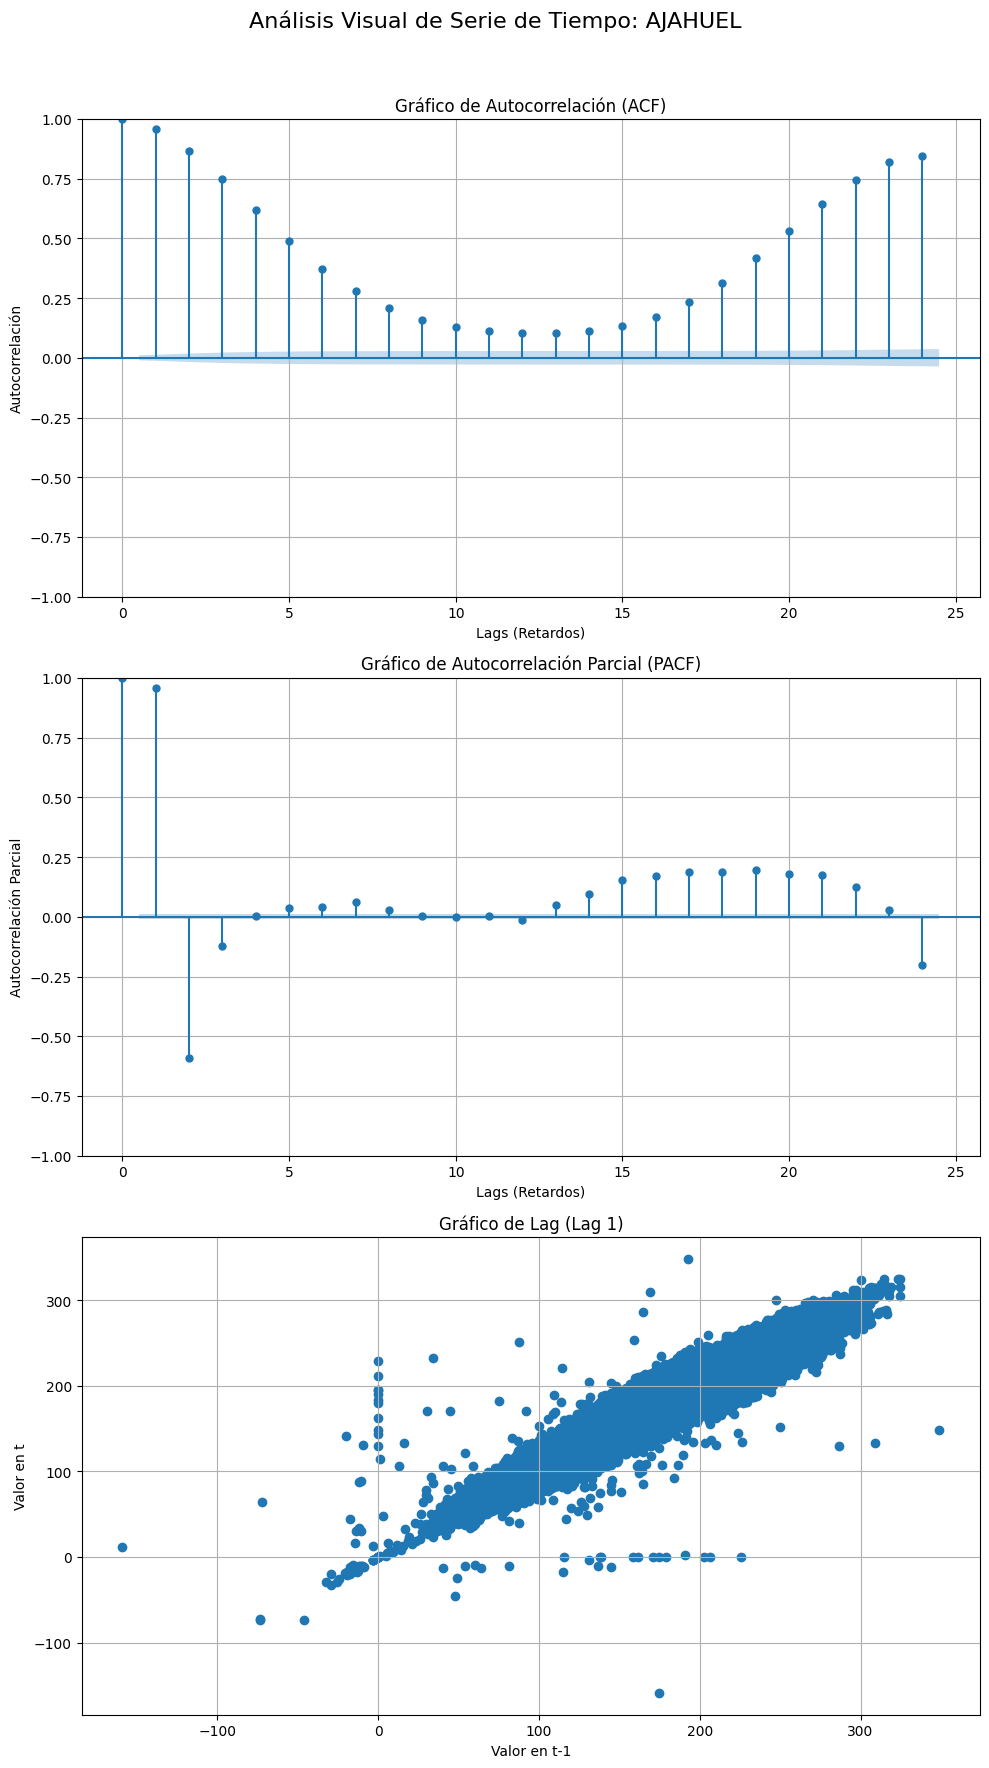

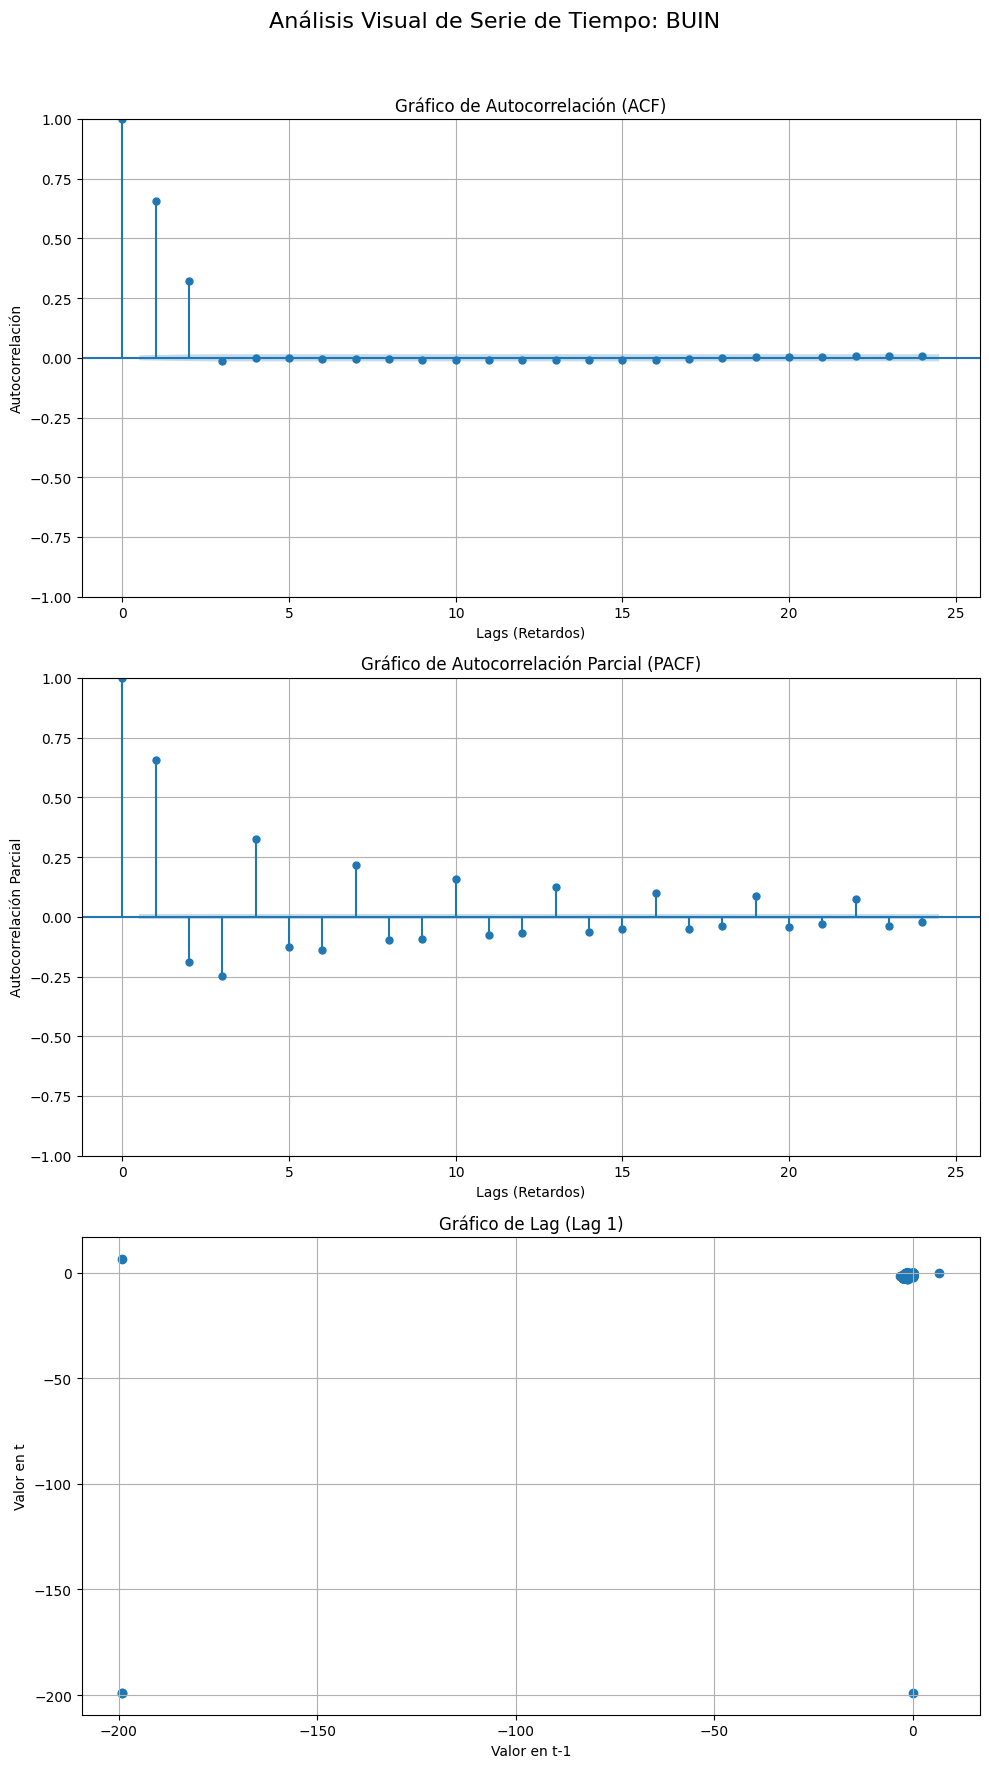

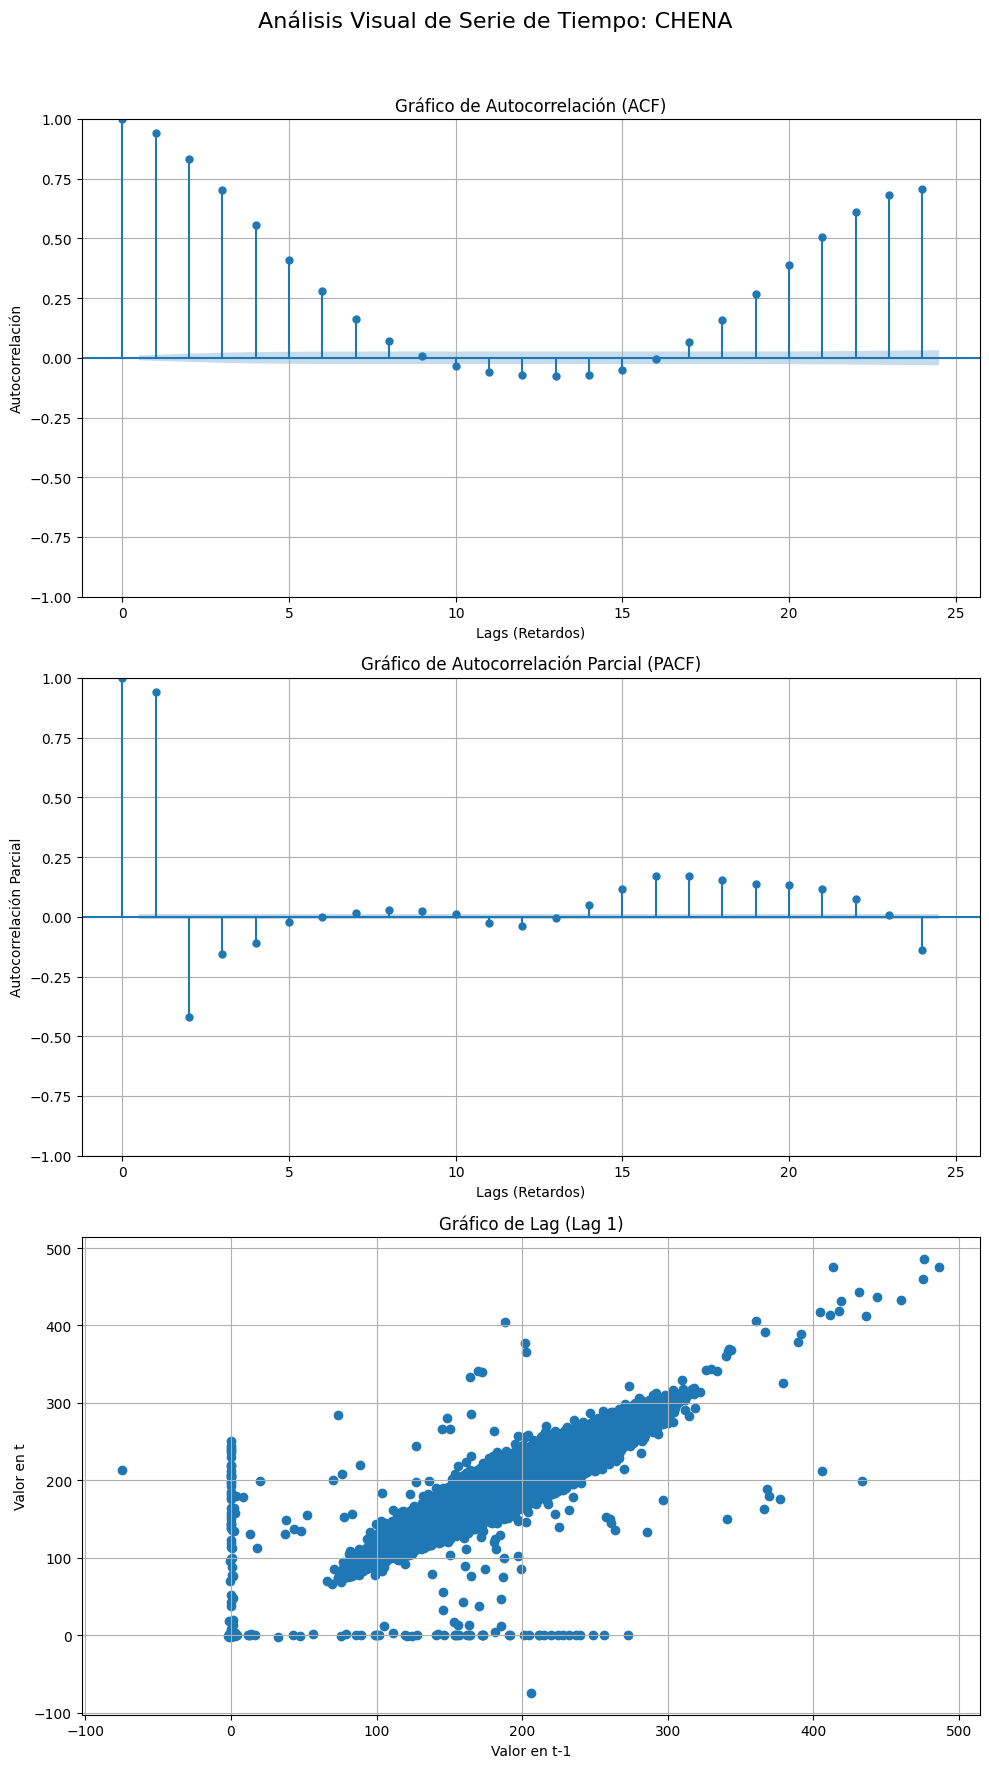

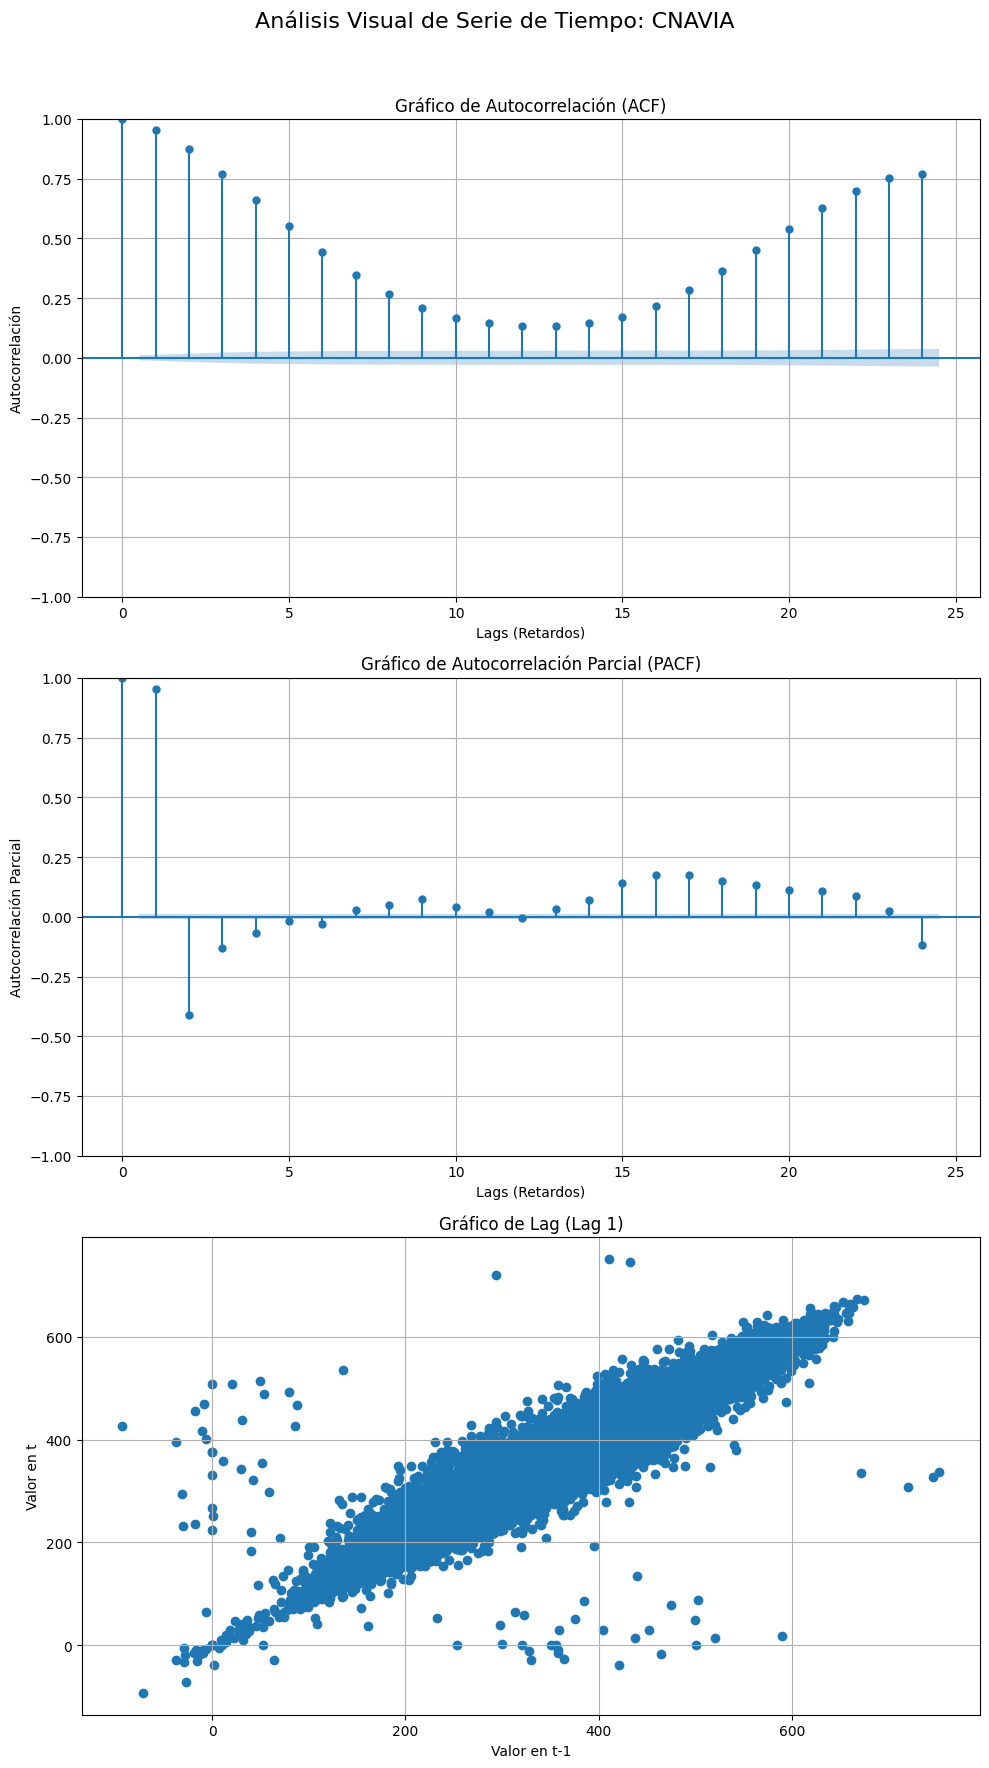

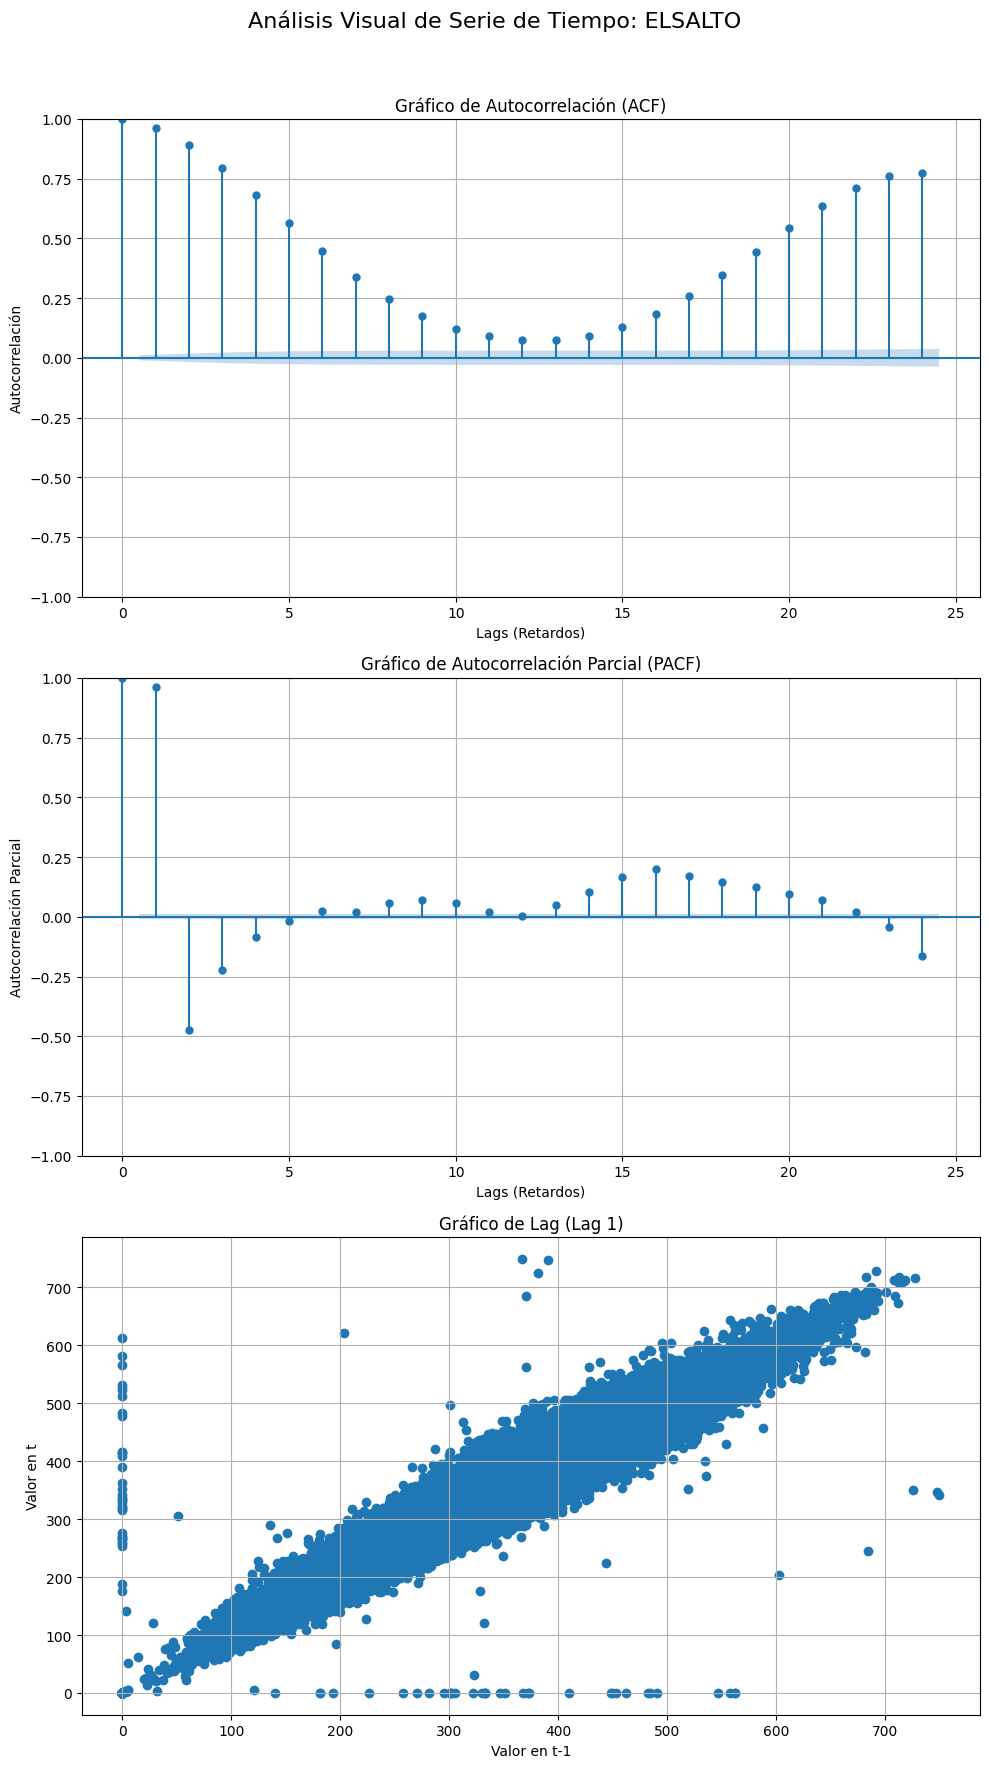

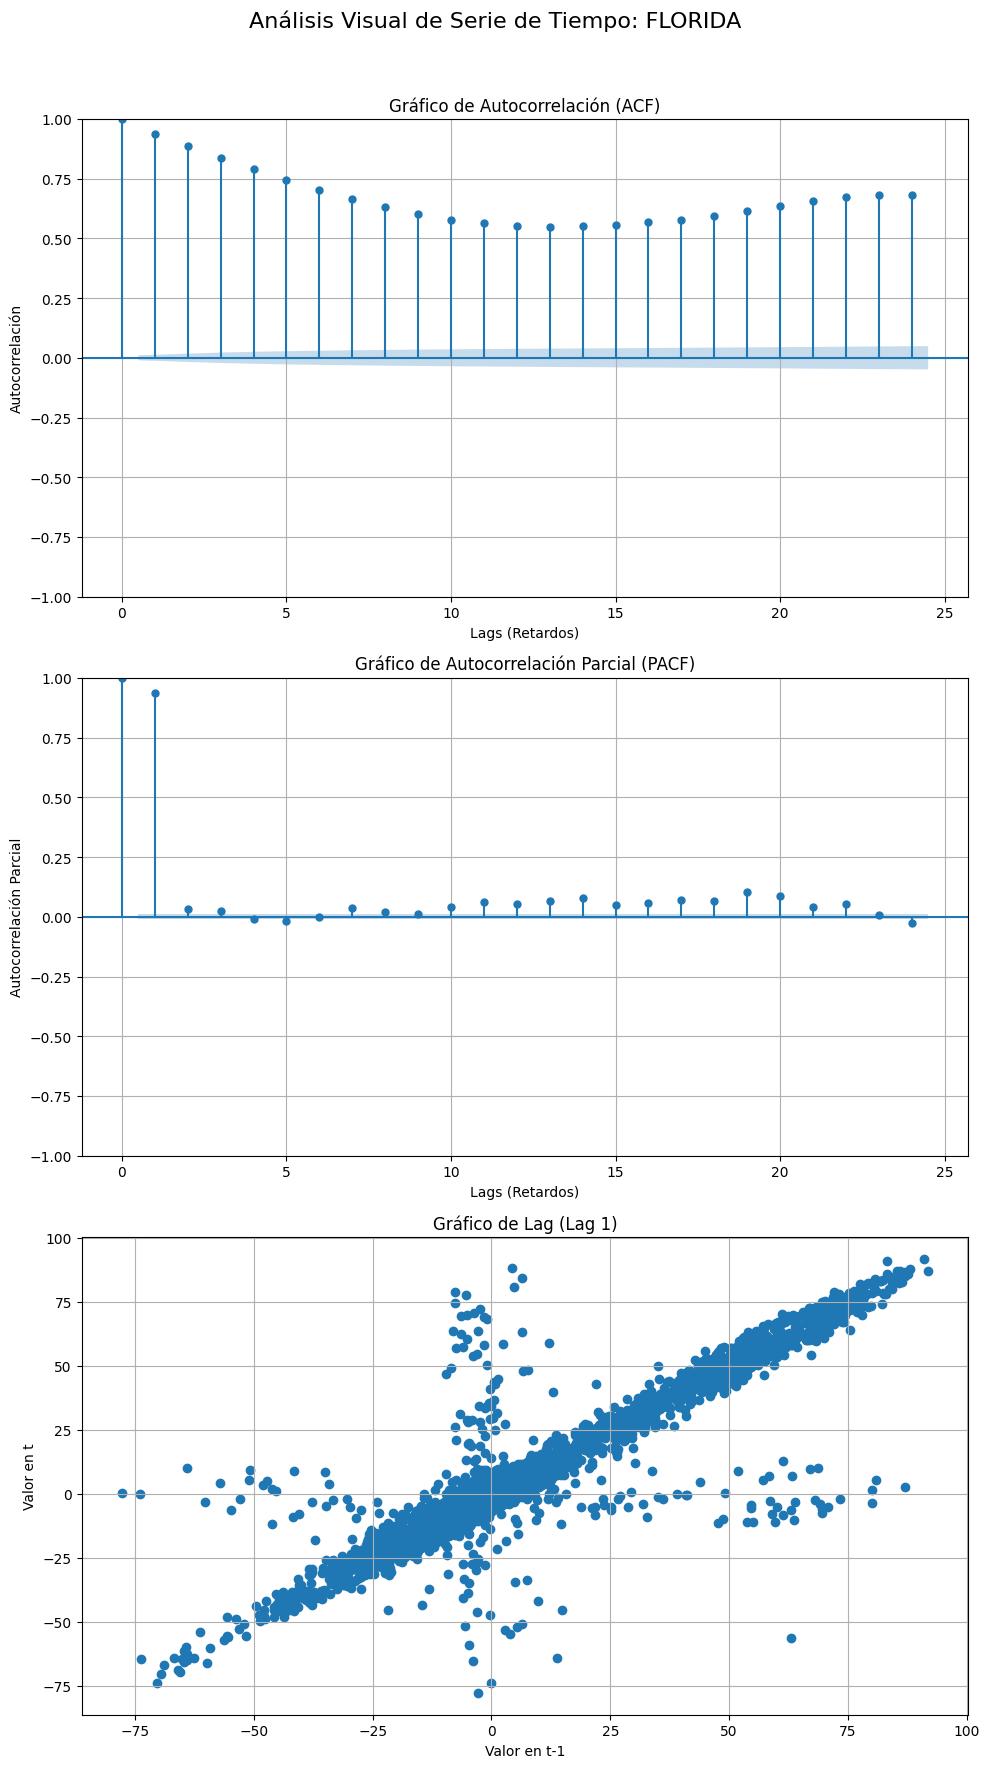

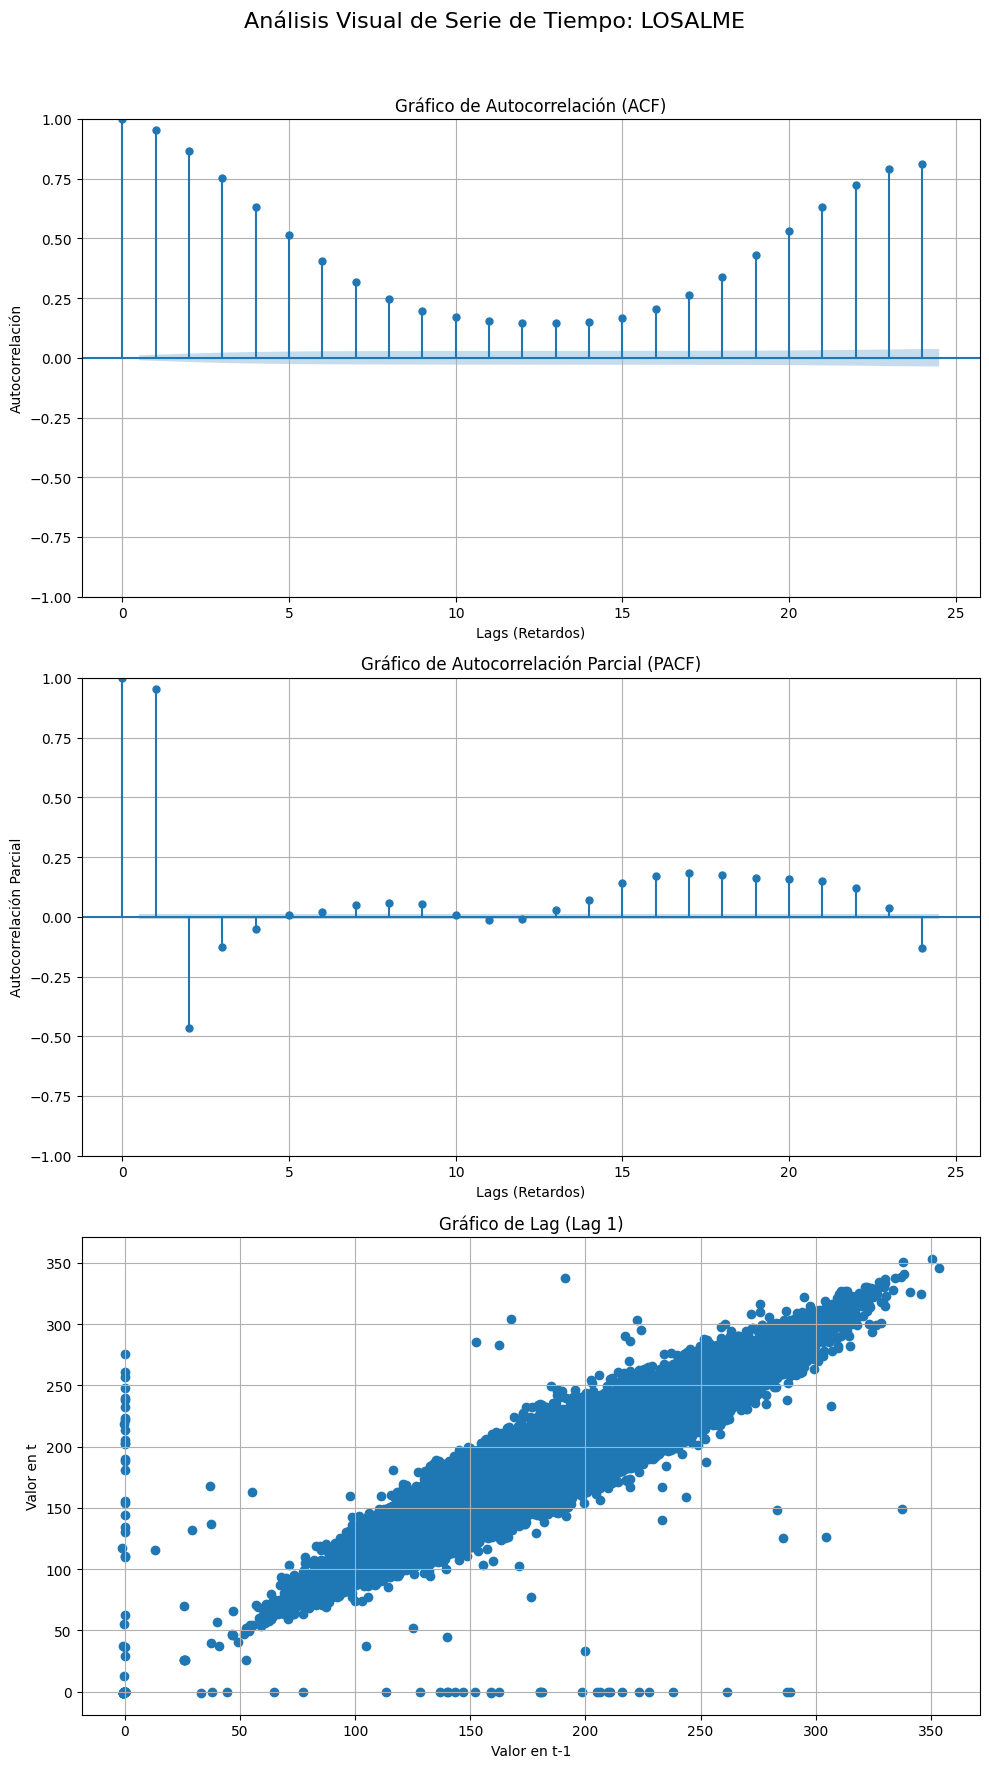

In [15]:
# Generación del Gráfico de Autocorrelación ---
print("\nGraficos de Autocorrelación para cada subestación...")
unique_substations = train_df['substation'].unique()

for substation in unique_substations:
    print(f"Graficos de Autocorrelación para la subestación: {substation}")
    serie_de_tiempo = train_df[train_df['substation'] == substation]['consumption']

    # Definir el nombre del archivo de imagen de salida
    plot_filename = f'Gráfico_de_Autocorrelación/train_acf_pacf_lag_plot_{substation}.png'

    # 3. Crear una figura de Matplotlib que contendrá ambos gráficos
    #    - 2, 1 significa 2 filas, 1 columna de subplots.
    #    - figsize ajusta el tamaño de la imagen final.
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))
    fig.suptitle(f'Análisis Visual de Serie de Tiempo: {substation}', fontsize=16)

    # 4. Generar el Gráfico de Autocorrelación (ACF) en el primer subplot (axes[0])
    plot_acf(serie_de_tiempo, lags=24, ax=axes[0])
    axes[0].set_title('Gráfico de Autocorrelación (ACF)')
    axes[0].set_xlabel('Lags (Retardos)')
    axes[0].set_ylabel('Autocorrelación')
    axes[0].grid(True)

    # 5. Generar el Gráfico de Autocorrelación Parcial (PACF) en el segundo subplot (axes[1])
    plot_pacf(serie_de_tiempo, lags=24, ax=axes[1], method='ywm')
    axes[1].set_title('Gráfico de Autocorrelación Parcial (PACF)')
    axes[1].set_xlabel('Lags (Retardos)')
    axes[1].set_ylabel('Autocorrelación Parcial')
    axes[1].grid(True)

    # 6. Gráfico de Lag (Lag Plot) en el tercer subplot
    lag_plot(serie_de_tiempo,lag=1, ax=axes[2])
    axes[2].set_title('Gráfico de Lag (Lag 1)')
    axes[2].set_xlabel('Valor en t-1')
    axes[2].set_ylabel('Valor en t')
    axes[2].grid(True)

    # 6. Ajustar el espaciado entre los gráficos para que no se superpongan y guardar la figura
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect ajusta el espacio para el título principal
    plt.savefig(plot_filename)

    print(f"Gráfico '{plot_filename}' guardado con éxito.")

    # Opcional: si estás ejecutando esto interactivamente y quieres ver el gráfico en pantalla
    #plt.show()


Graficos de Autocorrelación para cada subestación...
Graficos de Autocorrelación para la subestación: AJAHUEL
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_AJAHUEL.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: BUIN
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_BUIN.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: CHENA
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_CHENA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: CNAVIA
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_CNAVIA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: ELSALTO
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_ELSALTO.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: FLORIDA
Gráfico 'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_FLORIDA.png' guardado con éxito.
Graficos de Autocorrelación para la subestación: LOSALME
Gráfico

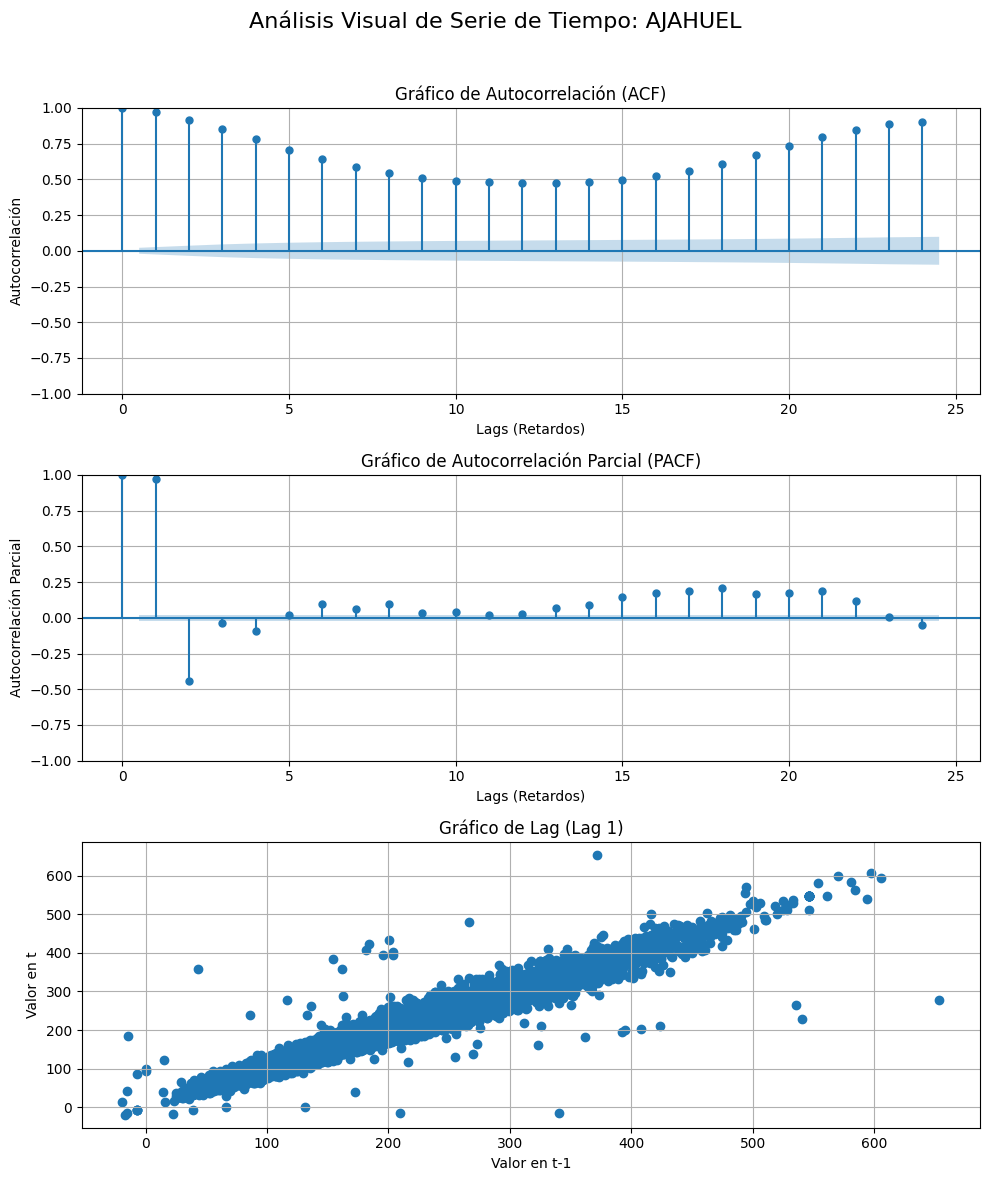

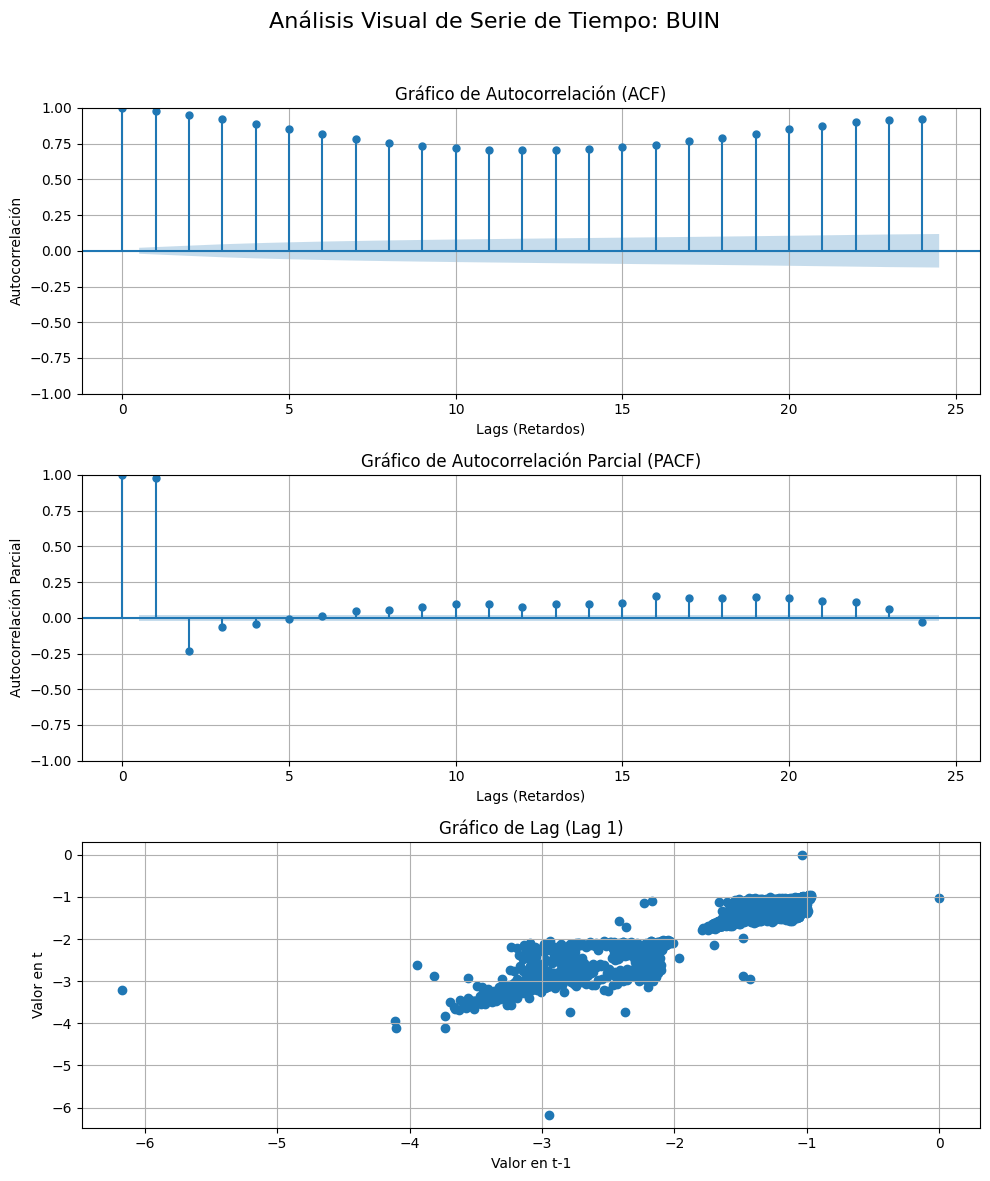

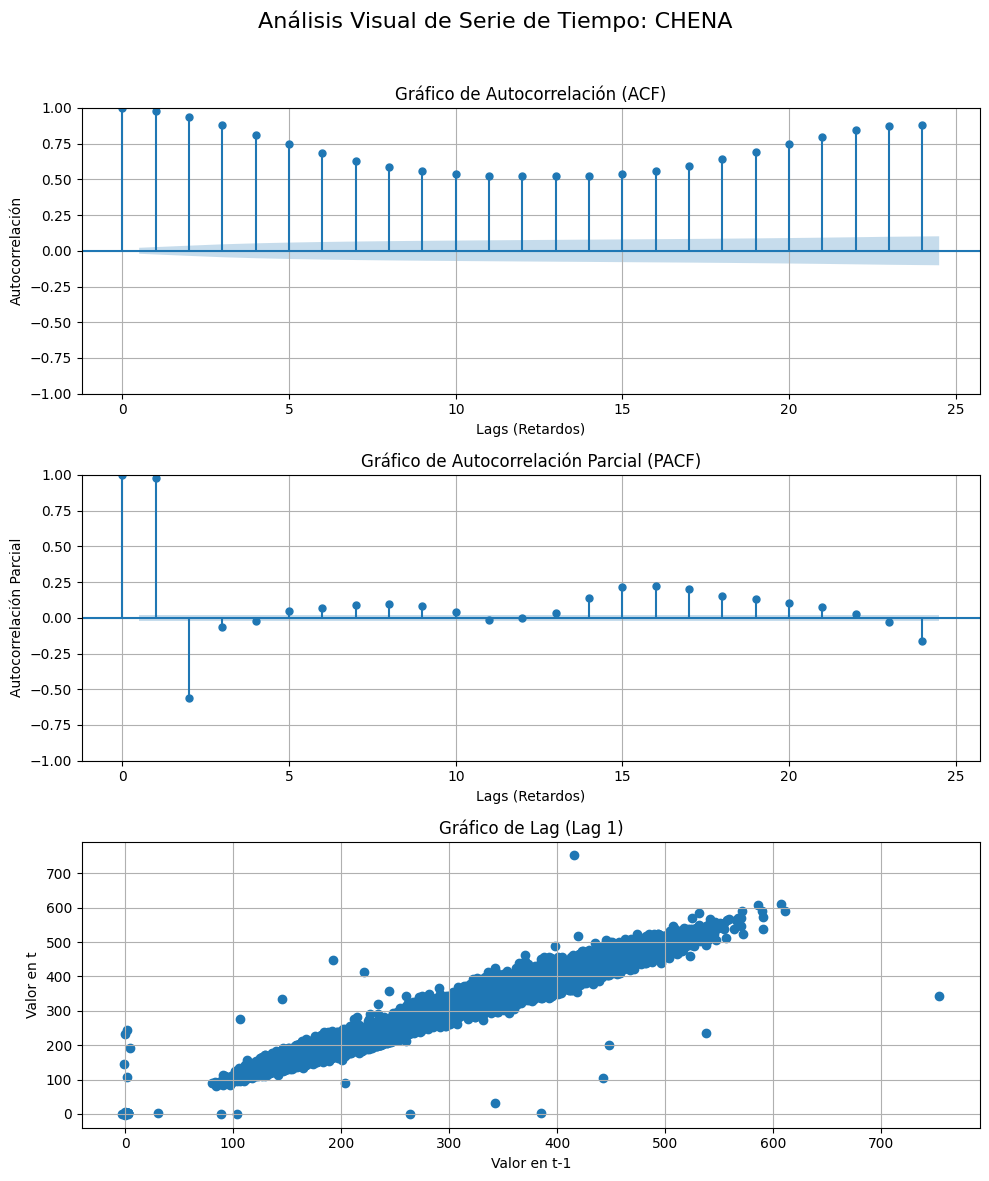

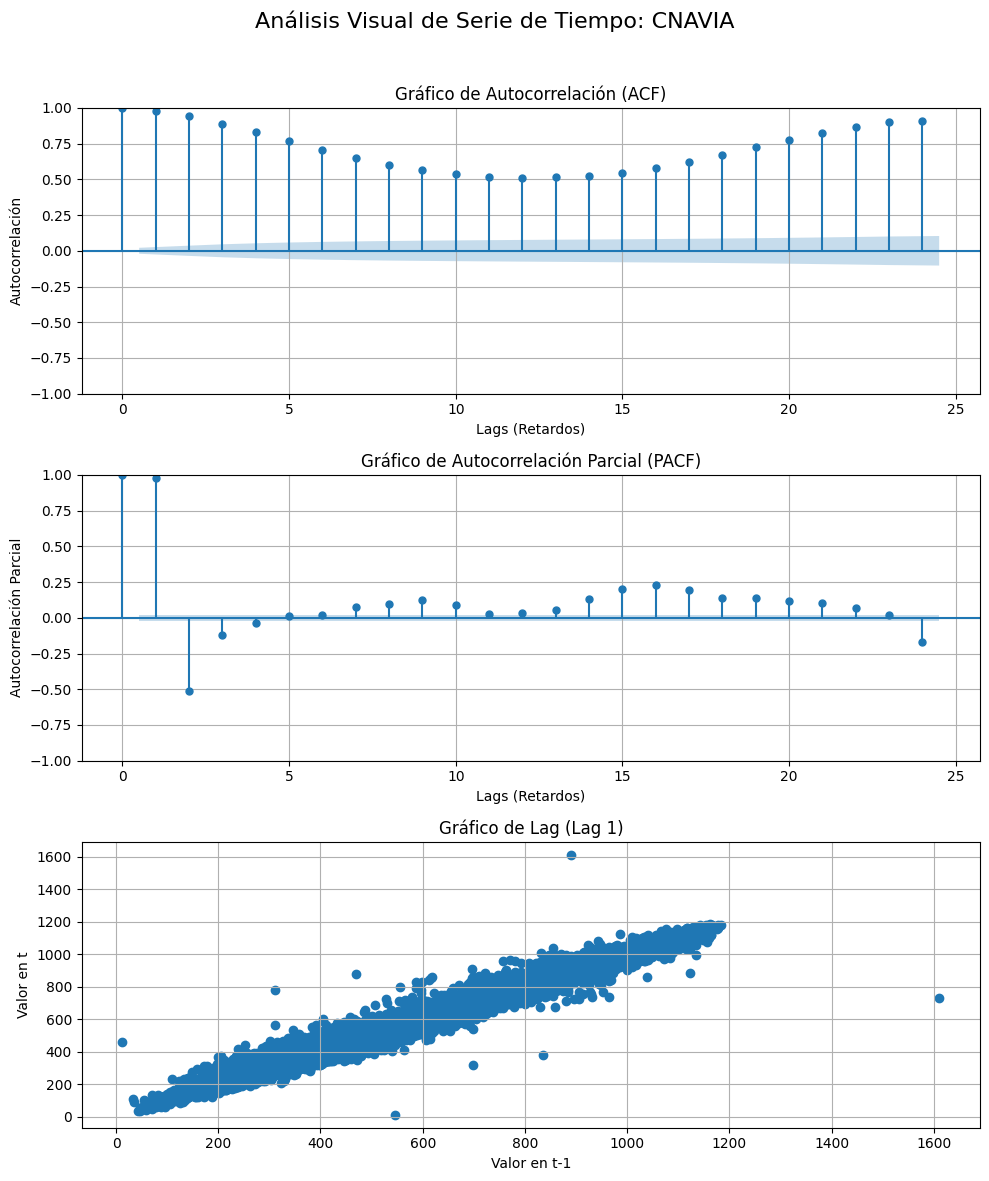

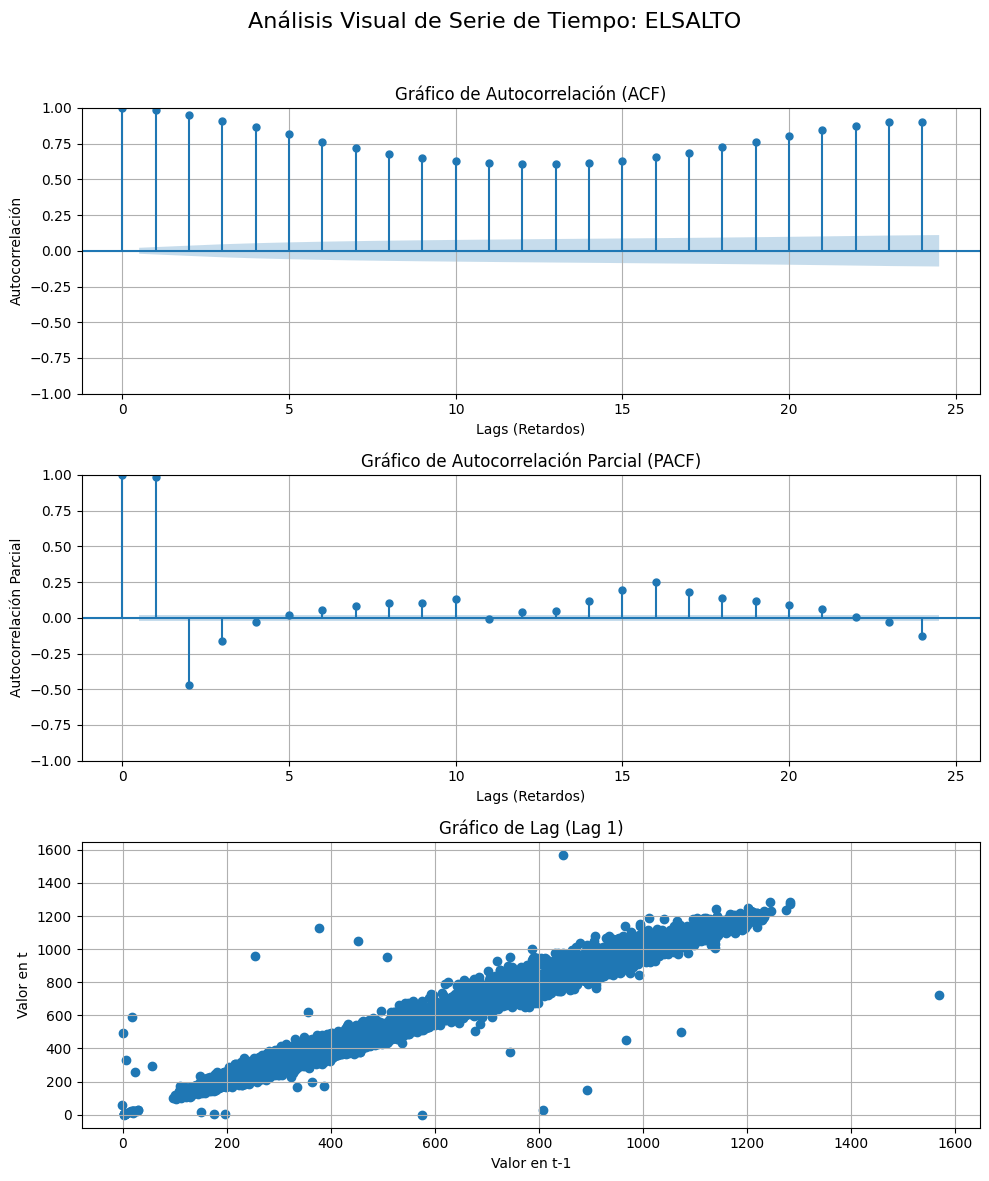

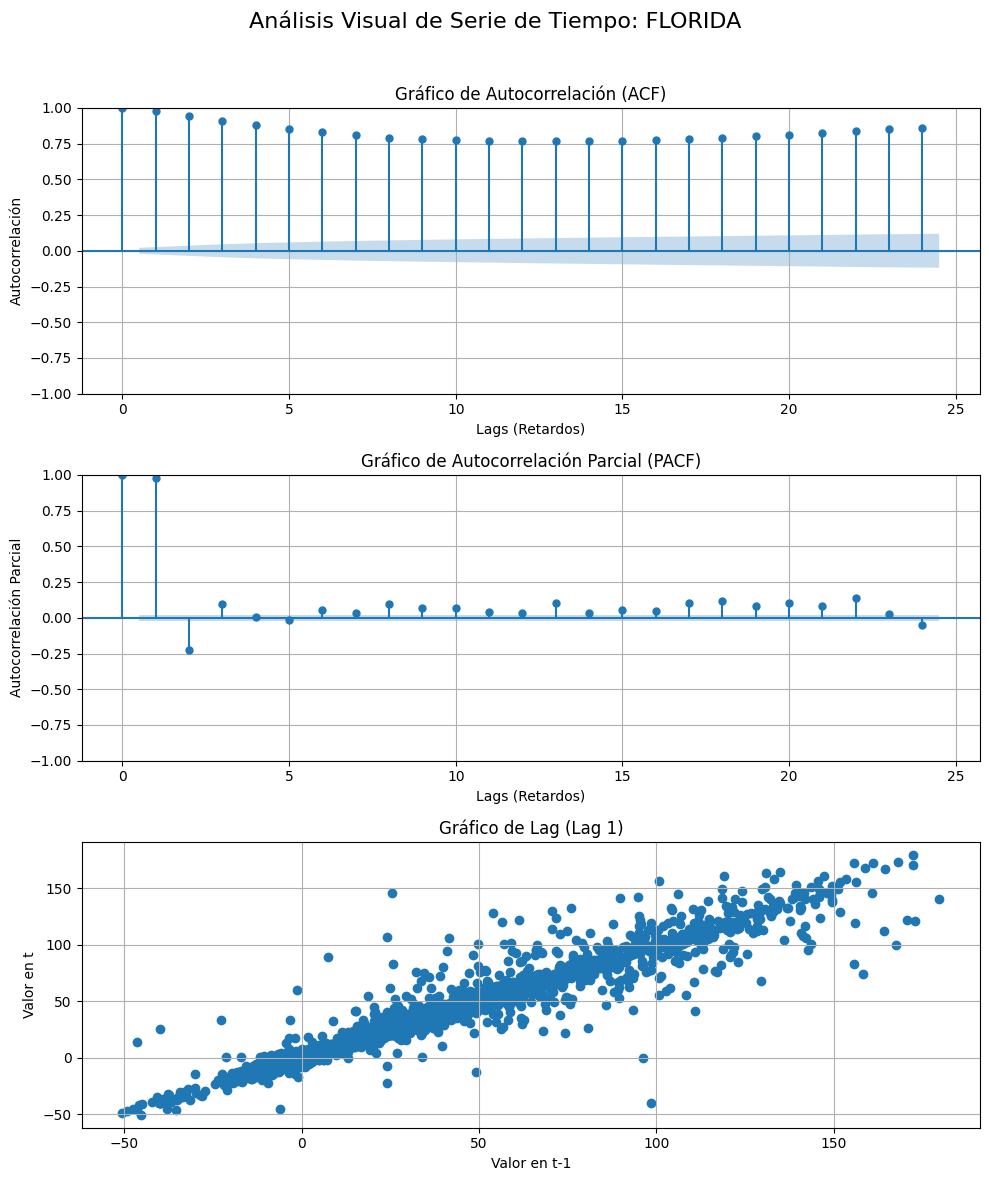

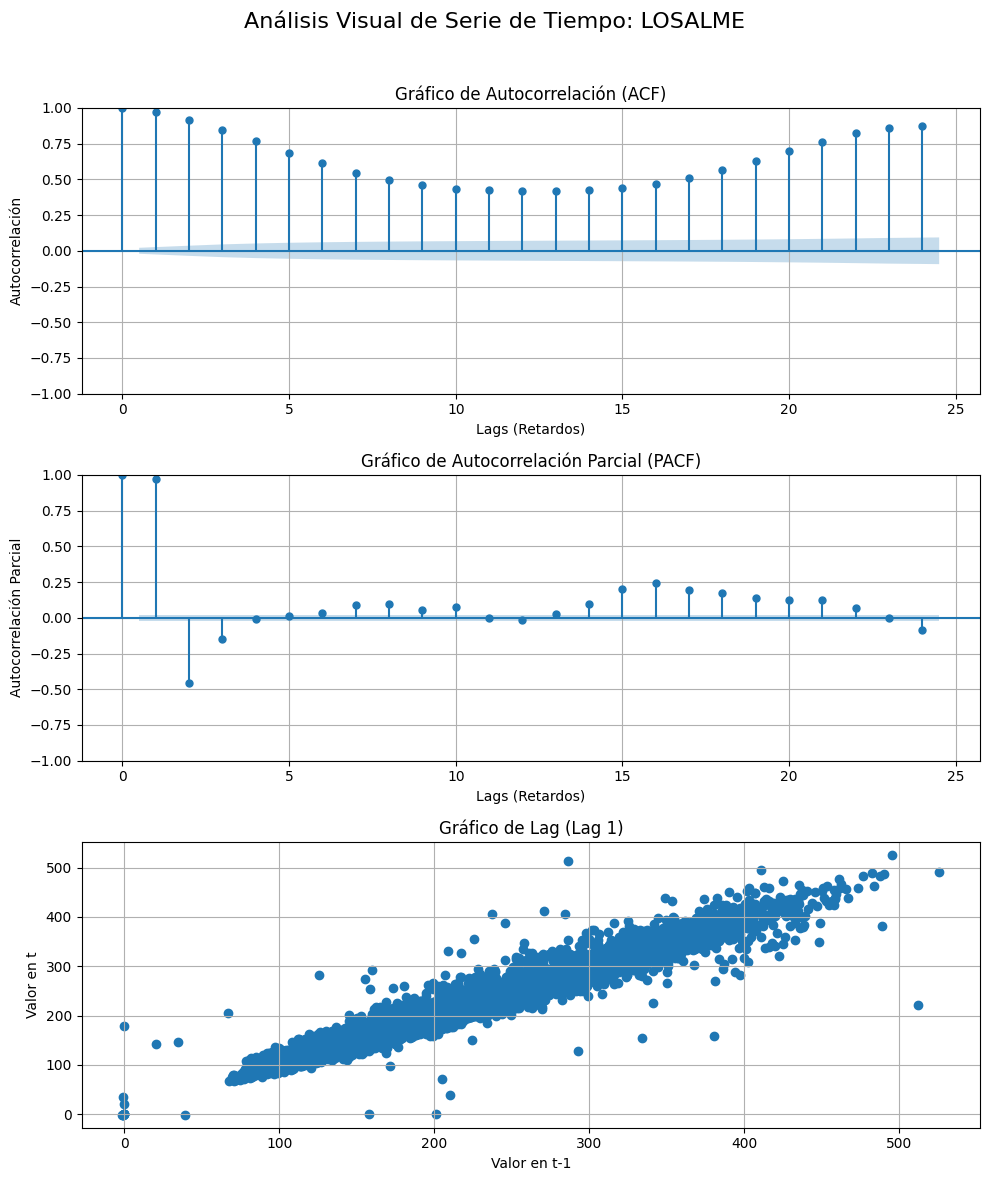

In [16]:
# Generación del Gráfico de Autocorrelación ---
print("\nGraficos de Autocorrelación para cada subestación...")
unique_substations = test_df['substation'].unique()

for substation in unique_substations:
    print(f"Graficos de Autocorrelación para la subestación: {substation}")
    serie_de_tiempo = test_df[test_df['substation'] == substation]['consumption']

    # Definir el nombre del archivo de imagen de salida
    plot_filename = f'Gráfico_de_Autocorrelación/test_acf_pacf_lag_plot_{substation}.png'

    # 3. Crear una figura de Matplotlib que contendrá ambos gráficos
    #    - 2, 1 significa 2 filas, 1 columna de subplots.
    #    - figsize ajusta el tamaño de la imagen final.
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(f'Análisis Visual de Serie de Tiempo: {substation}', fontsize=16)

    # 4. Generar el Gráfico de Autocorrelación (ACF) en el primer subplot (axes[0])
    plot_acf(serie_de_tiempo, lags=24, ax=axes[0])
    axes[0].set_title('Gráfico de Autocorrelación (ACF)')
    axes[0].set_xlabel('Lags (Retardos)')
    axes[0].set_ylabel('Autocorrelación')
    axes[0].grid(True)

    # 5. Generar el Gráfico de Autocorrelación Parcial (PACF) en el segundo subplot (axes[1])
    plot_pacf(serie_de_tiempo, lags=24, ax=axes[1], method='ywm')
    axes[1].set_title('Gráfico de Autocorrelación Parcial (PACF)')
    axes[1].set_xlabel('Lags (Retardos)')
    axes[1].set_ylabel('Autocorrelación Parcial')
    axes[1].grid(True)

    # 6. Gráfico de Lag (Lag Plot) en el tercer subplot
    lag_plot(serie_de_tiempo,lag=1, ax=axes[2])
    axes[2].set_title('Gráfico de Lag (Lag 1)')
    axes[2].set_xlabel('Valor en t-1')
    axes[2].set_ylabel('Valor en t')
    axes[2].grid(True)

    # 6. Ajustar el espaciado entre los gráficos para que no se superpongan y guardar la figura
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # rect ajusta el espacio para el título principal
    plt.savefig(plot_filename)

    print(f"Gráfico '{plot_filename}' guardado con éxito.")

    # Opcional: si estás ejecutando esto interactivamente y quieres ver el gráfico en pantalla
    #plt.show()

In [14]:
# --- 2. Preprocesamiento y Creación de Features ---
print("\n2. Preprocesamiento y Creación de Features")

def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

def weigh_outliers_to_mean(df, column, window=24, n_std=3, weight=0.5):
    """
    Identifica outliers y los pondera hacia la media móvil de su ventana.
    Un peso de 0.5 significa que el nuevo valor será el 50% del valor original y el 50% de la media.
    """
    df_out = df.copy()

    # Se calcula la media y desviación estándar móvil por cada subestación
    for substation in df_out['substation'].unique():
        # Filtrar por subestación
        subset = df_out[df_out['substation'] == substation]

        # Calcular media y std móvil
        rolling_mean = subset[column].rolling(window=window, center=True, min_periods=1).mean()
        rolling_std = subset[column].rolling(window=window, center=True, min_periods=1).std()

        # Definir límites para outliers
        upper_bound = rolling_mean + (n_std * rolling_std)
        lower_bound = rolling_mean - (n_std * rolling_std)

        # Identificar outliers
        is_outlier = (subset[column] < lower_bound) | (subset[column] > upper_bound)
        outlier_indices = subset[is_outlier].index

        # Si hay outliers, ponderarlos
        if not outlier_indices.empty:
            # Calcular el nuevo valor ponderado
            weighted_value = (weight * subset.loc[outlier_indices, column]) + ((1 - weight) * rolling_mean.loc[outlier_indices])
            # Asignar los nuevos valores en el dataframe de salida
            df_out.loc[outlier_indices, column] = weighted_value

    return df_out


2. Preprocesamiento y Creación de Features


In [15]:
# Aplicar la función de ponderación de outliers al dataset de entrenamiento
#print("\nPonderando outliers hacia la media...")
#train_df = weigh_outliers_to_mean(train_df, 'consumption')
#test_df = weigh_outliers_to_mean(test_df, 'consumption')
#print("\nPonderacion: Check!!")
print("\nCreando Caracteristicas...")
train_df = create_features(train_df)
test_df = create_features(test_df)
print("\nCreación de Caracteristicas: Check!!")


Creando Caracteristicas...

Creación de Caracteristicas: Check!!


In [16]:
# --- 3. Desarrollo de Modelos ---
print("\n3. Desarrollo de Modelos")


3. Desarrollo de Modelos


In [ ]:
# --- Modelo 1: SARIMA (en cada subestación) ---
print("\nEntrenando modelos SARIMA para cada subestación...")
unique_substations = train_df['substation'].unique()
sarima_predictions = {}

# Create a directory to save SARIMA models if it doesn't exist
sarima_models_dir = 'sarima_models'
if not os.path.exists(sarima_models_dir):
    os.makedirs(sarima_models_dir)

for substation in unique_substations:
    print(f"Entrenando SARIMA para la subestación: {substation}")
    # SARIMA es univariado, por lo que lo entrenamos en una sola subestación.
    # Usamos solo el último año de datos para acelerar el entrenamiento.
    train_sarima = train_df[train_df['substation'] == substation]['consumption']
    test_sarima = test_df[test_df['substation'] == substation]['consumption']

    # Parámetros para datos horarios con estacionalidad diaria (s=24)
    try:
        sarima_model = SARIMAX(train_sarima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
        sarima_fit = sarima_model.fit(disp=False)

        # Save the trained SARIMA model
        model_filename = os.path.join(sarima_models_dir, f'sarima_model_{substation}.pkl')
        with open(model_filename, 'wb') as pkl:
            pickle.dump(sarima_fit, pkl)
        print(f"Modelo SARIMA para {substation} guardado en {model_filename}")

        sarima_pred = sarima_fit.get_forecast(steps=len(test_sarima))
        sarima_predictions[substation] = pd.Series(sarima_pred.predicted_mean)
        sarima_predictions[substation].index = test_sarima.index
        print(f"Entrenamiento y predicción de SARIMA para {substation} completados.")

        # Visualización de las predicciones SARIMA vs. reales para la subestación
        plt.figure(figsize=(15, 6))
        plt.plot(test_sarima.index, test_sarima.values, label='Valores Reales')
        plt.plot(sarima_predictions[substation].index, sarima_predictions[substation].values, label='Predicciones SARIMA', alpha=0.7)
        plt.title(f'Comparación de Predicciones vs. Valores Reales (SARIMA en {substation})')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'sarima_predictions_{substation}.png')
        plt.close()
        print(f"Gráfico para {substation} guardado.")

    except Exception as e:
        print(f"Error al entrenar o predecir con SARIMA para {substation}: {e}")
        sarima_predictions[substation] = pd.Series(index=test_sarima.index) # Add empty series in case of error


Entrenando modelos SARIMA para cada subestación...
Entrenando SARIMA para la subestación: LOSALME
Modelo SARIMA para LOSALME guardado en sarima_models\sarima_model_LOSALME.pkl
Entrenamiento y predicción de SARIMA para LOSALME completados.
Gráfico para LOSALME guardado.


In [21]:
# --- Modelo 2: XGBoost (en todas las subestaciones) ---
print("\nEntrenando modelo XGBoost...")
# Usamos one-hot encoding para la variable categórica 'substation'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_substation_encoded = encoder.fit_transform(train_df[['substation']])
test_substation_encoded = encoder.transform(test_df[['substation']])

features = ['hour', 'dayofweek', 'month', 'year', 'dayofyear']
X_train_cat = pd.DataFrame(train_substation_encoded, index=train_df.index, columns=encoder.get_feature_names_out())
X_test_cat = pd.DataFrame(test_substation_encoded, index=test_df.index, columns=encoder.get_feature_names_out())

X_train = pd.concat([train_df[features], X_train_cat], axis=1)
y_train = train_df['consumption']
X_test = pd.concat([test_df[features], X_test_cat], axis=1)
y_test = test_df['consumption']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_pred = xgb_model.predict(X_test)
test_df['xgb_pred'] = xgb_pred # Añadir predicciones al df para filtrar por subestación


Entrenando modelo XGBoost...


In [22]:
# --- Modelo 3: LSTM (en cada subestación) ---
print("\nEntrenando modelos LSTM para cada subestación...")
unique_substations = train_df['substation'].unique()

lstm_predictions = {}

for substation in unique_substations:
    print(f"Entrenando LSTM para la subestación: {substation}")

    train_lstm_df = train_df[train_df['substation'] == substation][['consumption']]
    test_lstm_df = test_df[test_df['substation'] == substation][['consumption']]

    # Escalado de datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(train_lstm_df)
    scaled_test = scaler.transform(test_lstm_df) # Scale test data separately

    # Prepare data for LSTM (using a look_back window)
    def create_sequences(data, look_back=24):
        X, y = [], []
        for i in range(look_back, len(data)):
            X.append(data[i-look_back:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    look_back = 24
    X_train_lstm, y_train_lstm = create_sequences(scaled_train, look_back)

    # Create test sequences from the scaled test data
    X_test_lstm, y_test_lstm = create_sequences(scaled_test, look_back)


    X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    # Construir y entrenar el modelo LSTM
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        LSTM(50),
        Dense(1)
    ])
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')

    try:
        # Add error handling for training
        history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, verbose=0)

        lstm_pred_scaled = lstm_model.predict(X_test_lstm)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
        # Correctly index the predictions to match the test set dates after look_back
        lstm_predictions[substation] = pd.Series(lstm_pred.flatten(), index=test_lstm_df.index[look_back: look_back + len(lstm_pred)])


        print(f"Entrenamiento y predicción de LSTM para {substation} completados.")

        # Visualización de las predicciones LSTM vs. reales para la subestación
        plt.figure(figsize=(15, 6))
        # Plot actual values starting from the index that aligns with the first prediction
        plt.plot(test_lstm_df.index[look_back:], test_lstm_df.values[look_back:], label='Valores Reales')
        plt.plot(lstm_predictions[substation].index, lstm_predictions[substation].values, label='Predicciones LSTM', alpha=0.7)
        plt.title(f'Comparación de Predicciones vs. Valores Reales (LSTM en {substation})')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'lstm_predictions_{substation}.png')
        plt.close()
        print(f"Gráfico para {substation} guardado.")

    except Exception as e:
        print(f"Error al entrenar o predecir con LSTM para {substation}: {e}")
        # Store empty series if prediction fails, but ensure index matches test_lstm_df for consistency
        # Use the correct index range even if there's an error
        lstm_predictions[substation] = pd.Series(index=test_lstm_df.index[look_back:])


Entrenando modelos LSTM para cada subestación...
Entrenando LSTM para la subestación: AJAHUEL
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Entrenamiento y predicción de LSTM para AJAHUEL completados.
Gráfico para AJAHUEL guardado.
Entrenando LSTM para la subestación: BUIN
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Entrenamiento y predicción de LSTM para BUIN completados.
Gráfico para BUIN guardado.
Entrenando LSTM para la subestación: CHENA
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Entrenamiento y predicción de LSTM para CHENA completados.
Gráfico para CHENA guardado.
Entrenando LSTM para la subestación: CNAVIA
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Entrenamiento y predicción de LSTM para CNAVIA completados.
Gráfico para CNAVIA guardado.
Entrenando LSTM para la subestación: ELSALTO
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Entrenamiento y predicción de LSTM para ELSALTO completados.
Gráfico para ELSALTO guardado.
Entrenando LSTM para la subestación: FLORIDA
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3

In [31]:
# --- 4. Evaluación y Comparación ---
print("\n4. Evaluación y Comparación de modelos en cada subestación")

def evaluate_model(y_true, y_pred, model_name, substation_name):
    # Ensure y_true and y_pred have the same index and length
    common_index = y_true.index.intersection(y_pred.index)
    if len(common_index) == 0:
        print(f"Warning: No overlapping dates for {model_name} in {substation_name}. Cannot evaluate.")
        return {'Model': model_name, 'Substation': substation_name, 'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan}

    y_true_aligned = y_true.loc[common_index]
    y_pred_aligned = y_pred.loc[common_index]


    mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
    mse = mean_squared_error(y_true_aligned, y_pred_aligned)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_aligned, y_pred_aligned)
    return {'Model': model_name, 'Substation': substation_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results = []
unique_substations = test_df['substation'].unique()

for substation in unique_substations:
    print(f"Evaluando modelos para la subestación: {substation}")
    test_substation_data = test_df[test_df['substation'] == substation]['consumption']

    # SARIMA Evaluation
    if substation in sarima_predictions and not sarima_predictions[substation].empty:
         results.append(evaluate_model(test_substation_data, sarima_predictions[substation], 'SARIMA', substation))
    else:
         print(f"SARIMA predictions not available or empty for {substation}")

    # XGBoost Evaluation
    # Filter XGBoost predictions for the current substation
    xgb_pred_filtered = test_df[test_df['substation'] == substation]['xgb_pred']
    results.append(evaluate_model(test_substation_data, xgb_pred_filtered, 'XGBoost', substation))

    # LSTM Evaluation
    if substation in lstm_predictions and not lstm_predictions[substation].empty:
        results.append(evaluate_model(test_substation_data, lstm_predictions[substation], 'LSTM', substation))
    else:
         print(f"LSTM predictions not available or empty for {substation}")
    
    # LSTM ALL Evaluation
    # Filter LSTM ALL predictions for the current substation
    lstm_all_pred_filtered = test_df[test_df['substation'] == substation]['prediction_lstm_all']
    results.append(evaluate_model(test_substation_data, lstm_all_pred_filtered, 'LSTM_ALL', substation))


results_df = pd.DataFrame(results)
print("\nResultados de la evaluación:")
print(results_df)
results_df.to_csv('model_evaluation_results_1.csv', index=False)
print("\nArchivo 'model_evaluation_results_1.csv' guardado.")


4. Evaluación y Comparación de modelos en cada subestación
Evaluando modelos para la subestación: AJAHUEL


ValueError: Found input variables with inconsistent numbers of samples: [61145, 8735]

In [24]:
#Optional: Visualize comparison for a single substation (e.g., 'AJAHUEL')
substation_example = 'AJAHUEL'
plt.figure(figsize=(15, 6))
plt.plot(test_df[test_df['substation'] == substation_example]['consumption'].index, test_df[test_df['substation'] == substation_example]['consumption'].values, label='Valores Reales')
if substation_example in sarima_predictions and not sarima_predictions[substation_example].empty:
    plt.plot(sarima_predictions[substation_example].index, sarima_predictions[substation_example].values, label='Predicciones SARIMA', alpha=0.7)
plt.plot(test_df[test_df['substation'] == substation_example].index, test_df[test_df['substation'] == substation_example]['xgb_pred'].values, label='Predicciones XGBoost', alpha=0.7)
if substation_example in lstm_predictions and not lstm_predictions[substation_example].empty:
    plt.plot(lstm_predictions[substation_example].index, lstm_predictions[substation_example].values, label='Predicciones LSTM', alpha=0.7)
plt.title(f'Comparación de Predicciones vs. Valores Reales ({substation_example})')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.savefig(f'all_models_predictions_{substation_example}.png')
plt.close()

In [ ]:
# 1. Convertir el diccionario de Series a un único DataFrame
#df = pd.DataFrame(sarima_predictions)

# 2. Guardar el DataFrame en un archivo CSV
# index=True es importante para que la columna de fechas se guarde
#df.to_csv('sarima_predictions.csv', index=True)

# --- Para volver a cargarlo ---
# parse_dates=['date'] e index_col='date' son cruciales para reconstruir el DataFrame correctamente
#df_cargado = pd.read_csv('sarima_predictions.csv', index_col='date', parse_dates=['date'])
#print(df_cargado.head())

# Opcional: verifica que se cargó correctamente
#print("DataFrame cargado desde CSV:")
#print(df_cargado.head())
#print("\nInformación del DataFrame:")
#df_cargado.info()

# 2. Convertir el DataFrame de vuelta a un diccionario de Series
# El método .to_dict('series') hace exactamente esto: convierte cada columna en una Serie.
#sarima_predictions = df_cargado.to_dict('series')

# 3. ¡Listo! Ahora puedes verificar el resultado
#print("\nDiccionario reconstruido:")
# Imprimimos la primera clave para ver una de las Series
#print(sarima_predictions['AJAHUEL'])

                        AJAHUEL      BUIN       CHENA      CNAVIA     ELSALTO  \
date                                                                            
2022-01-01 00:00:00  102.356455 -1.254941  178.080624  350.235573  389.780550   
2022-01-01 01:00:00   80.168595 -1.251074  162.223359  318.447403  353.501245   
2022-01-01 02:00:00   60.699150 -1.214808  146.087417  290.193292  323.723738   
2022-01-01 03:00:00   46.051147 -1.183608  134.042010  269.462662  300.949465   
2022-01-01 04:00:00   38.688731 -1.180120  127.996227  257.661296  286.009540   

                       FLORIDA     LOSALME  
date                                        
2022-01-01 00:00:00 -12.232043  151.657610  
2022-01-01 01:00:00  -7.750145  140.528992  
2022-01-01 02:00:00  -3.618544  129.384806  
2022-01-01 03:00:00  -1.748106  121.717445  
2022-01-01 04:00:00  -1.850768  117.711817  
DataFrame cargado desde CSV:
                        AJAHUEL      BUIN       CHENA      CNAVIA     ELSALTO  \
date   


Average performance metrics for each model:
                MAE            MSE        RMSE         R2
Model                                                    
LSTM      12.164787     672.955280   20.944217   0.893067
SARIMA   214.811341  190564.141903  260.004061 -19.362737
XGBoost   77.590665   21700.129023  117.362180 -13.206568

Models sorted by average R2 score (higher is better):
                MAE            MSE        RMSE         R2
Model                                                    
LSTM      12.164787     672.955280   20.944217   0.893067
XGBoost   77.590665   21700.129023  117.362180 -13.206568
SARIMA   214.811341  190564.141903  260.004061 -19.362737

Models sorted by average MAE (lower is better):
                MAE            MSE        RMSE         R2
Model                                                    
LSTM      12.164787     672.955280   20.944217   0.893067
XGBoost   77.590665   21700.129023  117.362180 -13.206568
SARIMA   214.811341  190564.141903  260

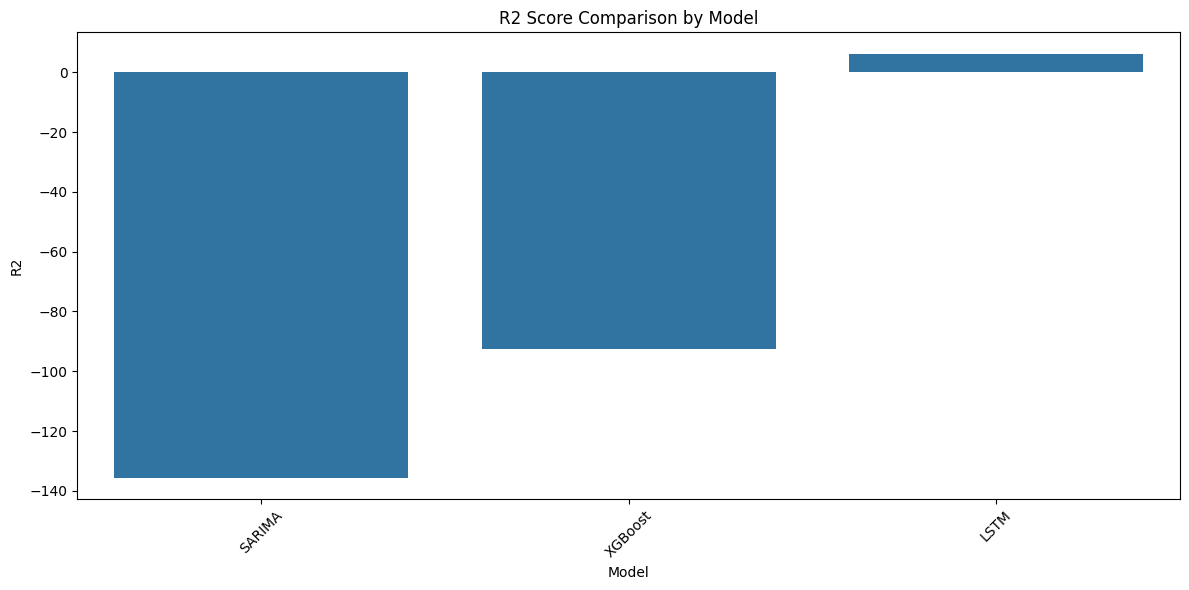

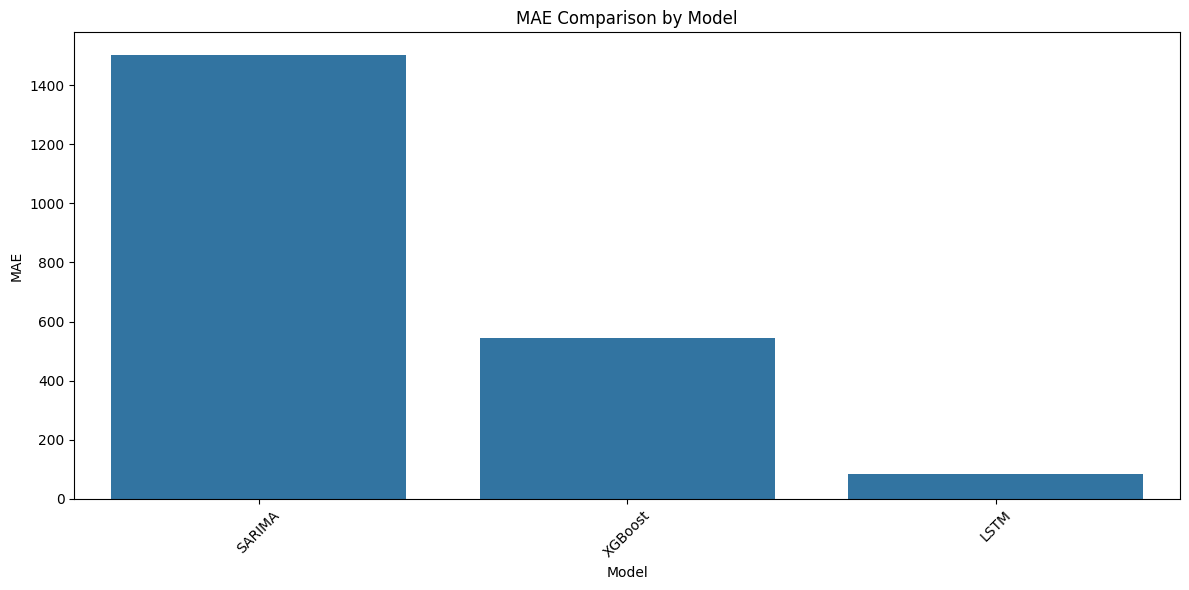

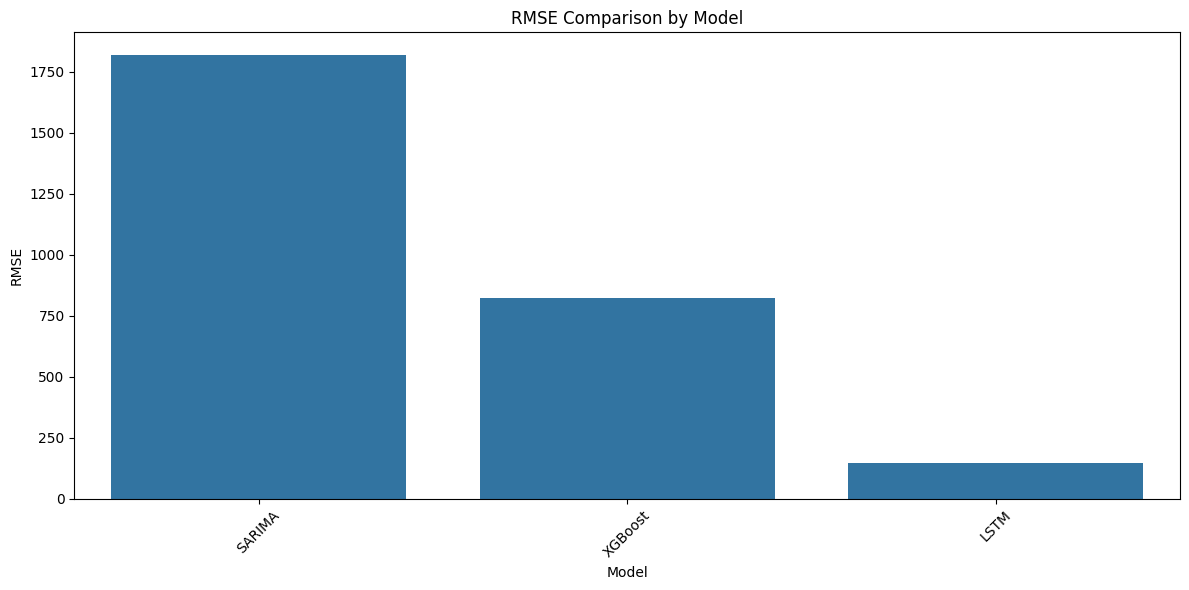

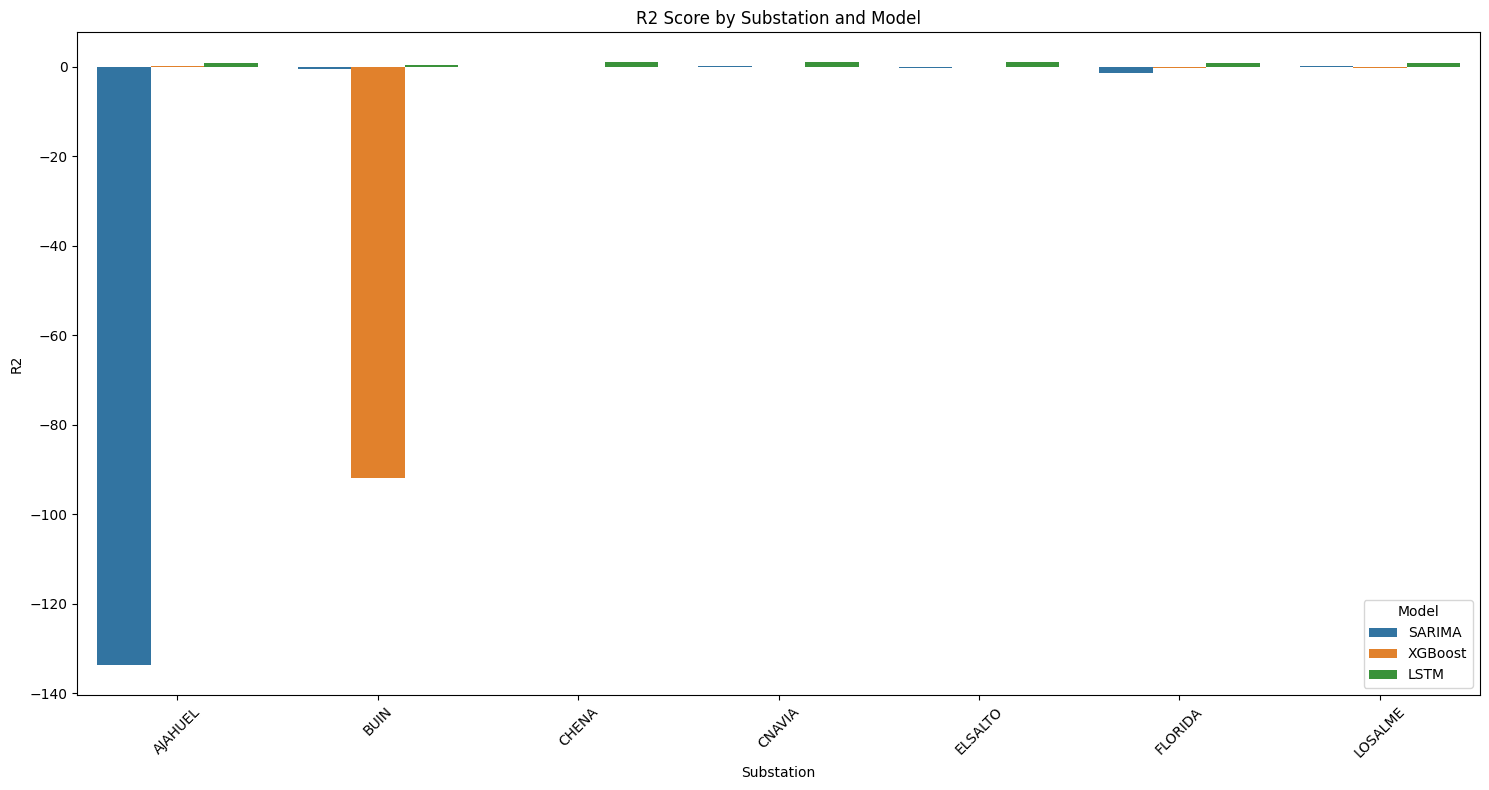

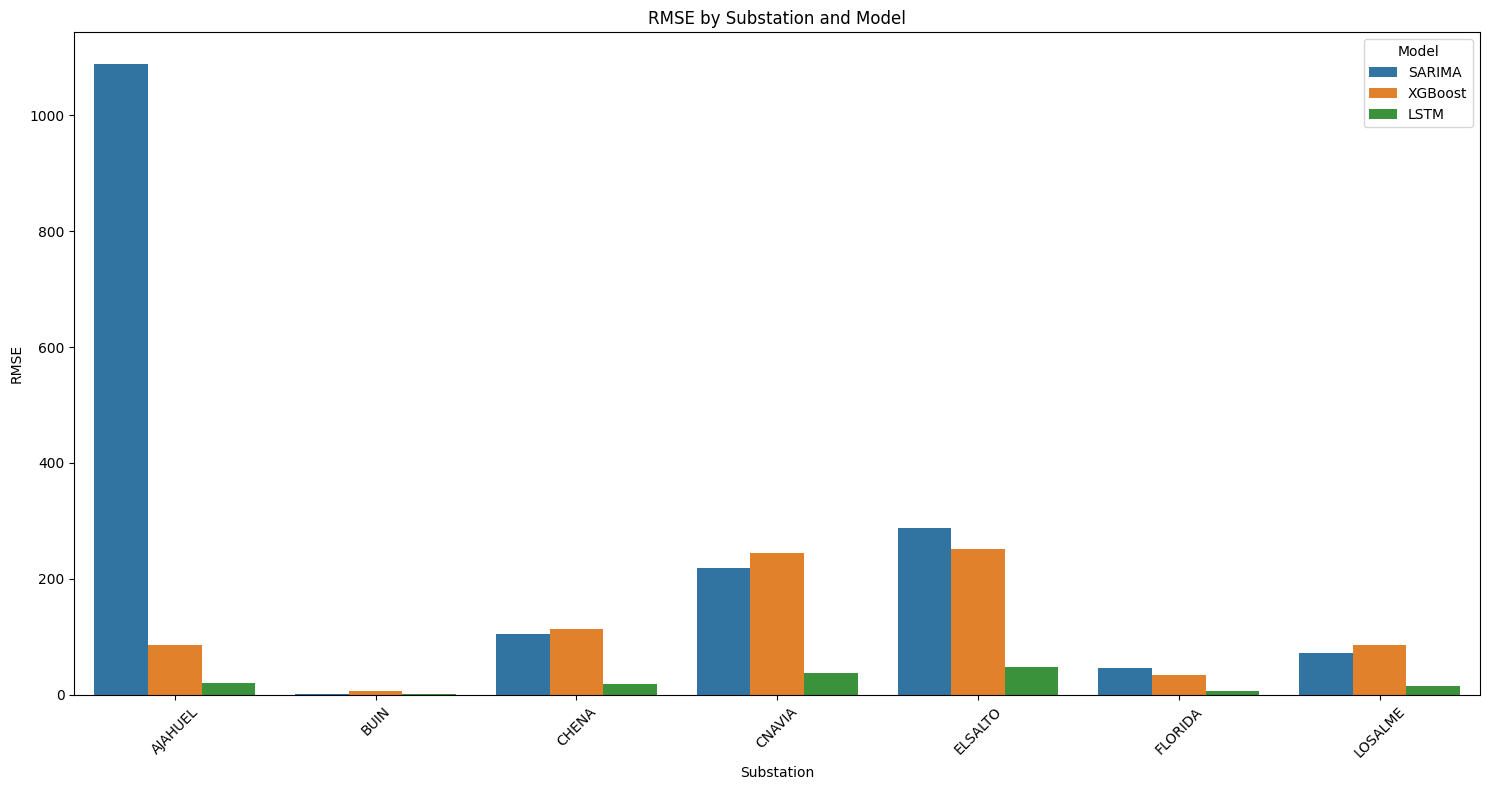

In [29]:
# Load the dataset
df = pd.read_csv('model_evaluation_results.csv')

# Calculate the average performance metrics for each model type
average_metrics = df.groupby(['Model']).mean(numeric_only=True)
print("\nAverage performance metrics for each model:")
print(average_metrics)

# Sort models by R2 score in descending order and other metrics in ascending order
sorted_r2 = average_metrics.sort_values('R2', ascending=False)
sorted_mae = average_metrics.sort_values('MAE', ascending=True)
sorted_rmse = average_metrics.sort_values('RMSE', ascending=True)

print("\nModels sorted by average R2 score (higher is better):")
print(sorted_r2)

print("\nModels sorted by average MAE (lower is better):")
print(sorted_mae)

print("\nModels sorted by average RMSE (lower is better):")
print(sorted_rmse)

# Create visualizations to compare model performance

# R2 Score comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', data=df, estimator=sum, ci=None)
plt.title('R2 Score Comparison by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('r2_score_comparison.png')


# MAE Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=df, estimator=sum, ci=None)
plt.title('MAE Comparison by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mae_comparison.png')

# RMSE Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=df, estimator=sum, ci=None)
plt.title('RMSE Comparison by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rmse_comparison.png')

# R2 Score by Substation and Model
plt.figure(figsize=(15, 8))
sns.barplot(x='Substation', y='R2', hue='Model', data=df)
plt.title('R2 Score by Substation and Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('r2_by_substation.png')

# RMSE by Substation and Model
plt.figure(figsize=(15, 8))
sns.barplot(x='Substation', y='RMSE', hue='Model', data=df)
plt.title('RMSE by Substation and Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rmse_by_substation.png')